In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from typing import Literal
from collections import defaultdict

sns.set_context("notebook")
sns.set_palette("deep")
color_palette = sns.color_palette()
color_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [2]:
FDF_GRAIN_SIZE: Literal["url", "context", "program"] = "url"

In [3]:
OUT_PATH = Path('output')
IN_PATH = Path('input')

In [4]:
df_raw = pd.read_pickle('output/0417-raf_final.pkl.zstd', compression='zstd')

In [5]:
idx = (((df_raw['when_webgl'].notna()) | (df_raw['trace_status'] == 'Ok')) & ~(df_raw['raf'] == True) & (df_raw['label_ERROR'].isnull()))
df_raw[idx]

,url,index_old,category,gl_info,duration,label_ERROR,label_usecase,label_interactions,label_comments,time_first_gl_call,...,raf-status-outer,raf-url-accessTime,raf-url-rafFuncCountList,raf-url-title,raf-url-usedOffScreenCanvas,raf-url-when,raf-url-whenDomContentLoadedEvent,raf-url-whenLoadEvent,raf-url-whenUsedWebgl,raf
10658,https://ipc.sonla.gov.vn/,-1.0,['bq'],None,63.427153,<NA>,<NA>,<NA>,<NA>,NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [6]:
def expand_and_merge(df_raw, col_name, prefix='', explode=False):
    df_tmp = df_raw[col_name].dropna()
    if explode:
        df_tmp = df_tmp.explode().dropna()

    df_tmp = df_tmp[df_tmp.apply(lambda x: isinstance(x, dict))]
    df_expand = pd.DataFrame(df_tmp.to_list(), index=df_tmp.index)
    df_ret = df_raw.drop(columns=[col_name]).merge(df_expand.add_prefix(prefix), left_index=True, right_index=True)
    return df_ret

In [7]:
# df_raw = pd.read_pickle(IN_PATH / 'df-all-merged-1.pkl.zstd', compression='zstd')
# df_huls = df_raw[df_raw.gl_info.apply(lambda x: x['whenUsedWebgl'] is not None if x is not None else False)].copy()
df_gl_info = expand_and_merge(df_raw[['url', 'category', 'duration', 'gl_info_raf']], 'gl_info_raf', 'raf-', explode=False)
df_gl_info

,url,category,duration,raf-accessTime,raf-contextInfo,raf-rafFuncCountList,raf-title,raf-url,raf-usedOffScreenCanvas,raf-when,raf-whenDomContentLoadedEvent,raf-whenLoadEvent,raf-whenUsedWebgl
0,http://0ldsk00l.ca/,['bq'],11.119047,1681713363510,[],[],0ldsk00l.ca,chrome-error://chromewebdata/,False,38769.7,8592.3,8593.2,NaN
1,http://1000.chromeexperiments.com,[awwwards],35.065929,1681459458925,[],[],"Chrome Experiment 1,000 by Google Data Arts Te...",https://experiments.withgoogle.com/chrome-expe...,False,33708.4,2122.3,3167.3,NaN
2,http://1000000-lives.com/,['bq'],19.773585,1681713404229,[],[],1000000-lives.com,chrome-error://chromewebdata/,False,38791.8,8601.9,8602.8,NaN
5,http://127.0.0.1:8000/test1/webgl/easy,[custom],30.827378,1681459501602,"[{'canvasContained': True, 'canvasHidden': Fal...",[2424],59.994 fps,http://127.0.0.1:8000/test1/webgl/easy,False,40625.7,151.6,151.7,144.5
6,http://127.0.0.1:8000/test1/webgl/hard,[custom],33.153617,1681459547533,"[{'canvasContained': True, 'canvasHidden': Fal...",[189],4.105 fps,http://127.0.0.1:8000/test1/webgl/hard,False,43844.0,651.6,651.6,174.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29223,https://zuplo.com/,[awwwards],33.459205,1681839732890,[],[],Zuplo API Management,https://zuplo.com/,False,33155.3,2477.8,10008.6,NaN
29231,https://zylotrade.com/,[tranco],38.730595,1681839805099,"[{'canvasContained': False, 'canvasHidden': Fa...","[242, 11943, 9]",Zylo Trade | Trading Platform | Best Forex and...,https://zylotrade.com/#home,True,70295.4,4174.6,NaN,2869.2
29233,https://zzm8.com/,['bq'],20.596767,1681839853453,"[{'canvasContained': False, 'canvasHidden': Fa...","[1, 1]",购彩中心 - 用户注册,https://668976.com:15288/register?id=51112457,False,43296.8,2921.9,2922.4,7285.1
29235,https://ggk.kz/,['bq'],22.345240,1681839899378,"[{'canvasContained': True, 'canvasHidden': Fal...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Геопортал РГП Госградкадастр,https://ggk.kz/,False,43996.7,3880.5,17696.6,3808.4


In [8]:
df_context = expand_and_merge(df_gl_info, 'raf-contextInfo', 'context-', explode=True)
df_context.index.name = 'index-url'
df_context.reset_index(inplace=True)
df_context.index.name = 'index-context'
df_context

,index-url,url,category,duration,raf-accessTime,raf-rafFuncCountList,raf-title,raf-url,raf-usedOffScreenCanvas,raf-when,...,context-canvasHidden,context-canvasSize,context-capturedFunctionsLength,context-contextAttributes,context-extensions,context-maghsk,context-memoryInfo,context-programInfo,context-triangleCount,context-vertexCount
index-context,,,,,,,,,,,,,,,,,,,,,
0,5,http://127.0.0.1:8000/test1/webgl/easy,[custom],30.827378,1681459501602,[2424],59.994 fps,http://127.0.0.1:8000/test1/webgl/easy,False,40625.7,...,False,"[800, 800]",4857,"{'alpha': True, 'antialias': True, 'depth': Tr...",[],"{'counter': {'bufferDataSent': 2880, 'bufferSu...","{'memory': {'buffer': 2880, 'drawingbuffer': 1...","[{'fragmentShaders': [], 'isDeleted': False, '...",None,1.453800e+06
1,6,http://127.0.0.1:8000/test1/webgl/hard,[custom],33.153617,1681459547533,[189],4.105 fps,http://127.0.0.1:8000/test1/webgl/hard,False,43844.0,...,False,"[800, 800]",387,"{'alpha': True, 'antialias': True, 'depth': Tr...",[],"{'counter': {'bufferDataSent': 2880, 'bufferSu...","{'memory': {'buffer': 2880, 'drawingbuffer': 1...","[{'fragmentShaders': [], 'isDeleted': False, '...",None,1.128000e+09
2,8,http://127.0.0.1:8000/test3/webgl/easy,[custom],30.765577,1681459634288,[2336],58.077 fps,http://127.0.0.1:8000/test3/webgl/easy,False,40366.4,...,False,"[800, 800]",4690,"{'alpha': True, 'antialias': True, 'depth': Tr...",[],"{'counter': {'bufferDataSent': 1641600, 'buffe...","{'memory': {'buffer': 1641600, 'drawingbuffer'...","[{'fragmentShaders': [], 'isDeleted': False, '...",None,1.597140e+08
3,11,http://12storytellers.hands.agency,[awwwards],51.905072,1681512801444,"[2394, 7182, 1]",Hands | Carte de Voeux,https://12storytellers.hands.agency/,False,43463.1,...,False,"[1408, 729]",204369,"{'alpha': True, 'antialias': False, 'depth': T...","[OES_vertex_array_object, OES_standard_derivat...","{'counter': {'bufferDataSent': 8580, 'bufferSu...","{'memory': {'buffer': 8580, 'drawingbuffer': 1...","[{'fragmentShaders': [], 'isDeleted': False, '...",None,1.936764e+06
4,14,http://17grad.com,[awwwards],31.976162,1681459765939,[1],17ºStudio – Berlin-based Web Design Agency,https://17grad.com/,False,42719.3,...,False,"[1396, 727]",3,"{'alpha': True, 'antialias': False, 'depth': T...","[EXT_color_buffer_float, OES_texture_float_lin...","{'counter': {'bufferDataSent': 0, 'bufferSubDa...","{'memory': {'buffer': 0, 'drawingbuffer': 1217...","[{'fragmentShaders': [], 'isDeleted': False, '...",None,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13669,29222,https://zuniversetextures.jimdofree.com/,['bq'],14.252283,1681839697307,[],Bem vindo - zuniversetextures,https://zuniversetextures.jimdofree.com/,False,43800.3,...,False,"[300, 150]",41,"{'alpha': True, 'antialias': True, 'depth': Tr...","[GMAN_webgl_memory, GMAN_webgl_memory, WEBGL_d...","{'counter': {'bufferDataSent': 108, 'bufferSub...","{'memory': {'buffer': 36, 'drawingbuffer': 108...","[{'fragmentShaders': [], 'isDeleted': False, '...",None,9.000000e+00
13670,29231,https://zylotrade.com/,[tranco],38.730595,1681839805099,"[242, 11943, 9]",Zylo Trade | Trading Platform | Best Forex and...,https://zylotrade.com/#home,True,70295.4,...,False,"[1408, 729]",4130,"{'alpha': True, 'antialias': False, 'depth': T...","[OES_texture_float, OES_texture_float_linear, ...","{'counter': {'bufferDataSent': 152, 'bufferSub...","{'memory': {'buffer': 152, 'drawingbuffer': 12...","[{'fragmentShaders': [], 'isDeleted': False, '...",None,0.000000e+00
13671,29233,https://zzm8.com/,['bq'],20.596767,1681839853453,"[1, 1]",购彩中心 - 用户注册,https://668976.com:15288/register?id=51112457,False,43296.8,...,False,"[300, 150]",1,"{'alpha': True, 'antialias': True, 'depth': Tr...",[WEBGL_debug_renderer_info],"{'counter': {'bufferDataSent': 0, 'bufferSubDa...","{'memory': {'buffer': 0, 'drawingbuffer': 1080...","[{'fragmentShaders': [], 'isDeleted': False, '...",None,0.000000e+00


In [9]:
df_context = expand_and_merge(df_context, 'context-contextAttributes', 'context-contextAttributes-')
df_context = expand_and_merge(df_context, 'context-maghsk', 'context-maghsk-')
df_context = expand_and_merge(df_context, 'context-memoryInfo', 'context-memoryInfo-')

df_context = expand_and_merge(df_context, 'context-maghsk-counter', 'context-maghsk-counter-')
df_context = expand_and_merge(df_context, 'context-memoryInfo-memory', 'context-memoryInfo-memory-')
df_context = expand_and_merge(df_context, 'context-memoryInfo-resources', 'context-memoryInfo-resources-')

df_context['context-type'] = df_context['context-maghsk-createArguments'].str[0]

In [10]:
df_context.loc[0].apply(lambda x: type(x)).to_dict()

{'index-url': numpy.int64,
 'url': str,
 'category': list,
 'duration': numpy.float64,
 'raf-accessTime': numpy.int64,
 'raf-rafFuncCountList': list,
 'raf-title': str,
 'raf-url': str,
 'raf-usedOffScreenCanvas': numpy.bool_,
 'raf-when': numpy.float64,
 'raf-whenDomContentLoadedEvent': numpy.float64,
 'raf-whenLoadEvent': numpy.float64,
 'raf-whenUsedWebgl': numpy.float64,
 'context-canvasContained': numpy.bool_,
 'context-canvasHidden': numpy.bool_,
 'context-canvasSize': list,
 'context-capturedFunctionsLength': numpy.int64,
 'context-extensions': list,
 'context-programInfo': list,
 'context-triangleCount': NoneType,
 'context-vertexCount': numpy.float64,
 'context-contextAttributes-alpha': numpy.bool_,
 'context-contextAttributes-antialias': numpy.bool_,
 'context-contextAttributes-depth': numpy.bool_,
 'context-contextAttributes-desynchronized': numpy.bool_,
 'context-contextAttributes-failIfMajorPerformanceCaveat': numpy.bool_,
 'context-contextAttributes-powerPreference': str,

In [11]:
canvas_length = df_context.groupby('index-url')['url'].count()
canvas_length

index-url
5        1
6        1
8        1
11       1
14       1
        ..
29222    3
29231    1
29233    1
29235    1
29238    1
Name: url, Length: 7694, dtype: int64

Figure out why a webpage contains more than one canvas. List some urls and their canvas counts.

In [12]:
# context length > 1
df_gl_info.loc[canvas_length[canvas_length > 1].index]

,url,category,duration,raf-accessTime,raf-contextInfo,raf-rafFuncCountList,raf-title,raf-url,raf-usedOffScreenCanvas,raf-when,raf-whenDomContentLoadedEvent,raf-whenLoadEvent,raf-whenUsedWebgl
index-url,,,,,,,,,,,,,
15,http://1j1d.art,[awwwards],60.032204,1681459810818,"[{'canvasContained': False, 'canvasHidden': Fa...","[2401, 9, 2399, 2399, 2399]",Un jour un dessin - Artiste peintre,https://1j1d.art/,True,42763.1,2558.6,2558.7,2574.1
20,http://2016.makemepulse.com,[awwwards],31.697993,1681459854689,"[{'canvasContained': True, 'canvasHidden': Fal...","[7232, 2410, 2380, 4700]",2016 Make Me Pulse,http://2016.makemepulse.com/,False,41640.1,1258.5,2543.2,1116.1
58,http://80.253.29.55:3001/Typ.html,[tranco],33.924748,1681460216270,"[{'canvasContained': False, 'canvasHidden': Fa...",[],New Project | Virtual tour generated by Panotour,http://80.253.29.55:3001/Typ.html,False,45691.6,5575.7,5576.1,5523.0
66,http://a-0.design,"[awwwards, cssdesign]",33.597942,1681460412478,"[{'canvasContained': False, 'canvasHidden': Fa...","[2317, 2053, 2053, 16]",A TO 0 DESIGN NEW YORK | A - 0,https://a-0.design/,False,43098.4,3116.6,7856.0,2685.5
68,http://a-way-to-go.com/,"[awwwards, threejs]",33.940502,1681512988721,"[{'canvasContained': False, 'canvasHidden': Fa...",[1518],WAY TO GO,http://a-way-to-go.com/,False,42485.7,1173.3,3788.8,2068.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29203,https://zoskinportal.jp/faq/,['bq'],13.265397,1681839228552,"[{'canvasContained': False, 'canvasHidden': Fa...","[2415, 2415, 2415]",ゼオスキンヘルスを知ろう｜Beauty Suport - キュテラ株式会社,https://zoskinportal.jp/faq/,True,41853.0,1661.1,2485.9,1618.5
29204,https://zoskinportal.jp/trouble/,['bq'],41.933194,1681839272508,"[{'canvasContained': False, 'canvasHidden': Fa...","[2429, 2429, 2429]",肌トラブルについて知ろう｜Beauty Suport - キュテラ株式会社,https://zoskinportal.jp/trouble/,True,41815.8,1392.8,2481.7,1346.0
29209,https://zspkleszczow.pl/spacer-wirtualny,['bq'],14.278903,1681839365735,"[{'canvasContained': False, 'canvasHidden': Fa...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Spacer wirtualny Zespołu Szkół Ponadpodstawowy...,https://zspkleszczow.pl/spacer-wirtualny/#node...,False,42294.4,2247.1,3766.4,3628.2


# In other words, could we detect the pattern of an empty canvas?

In [13]:
# tmp = df_raw[df_raw['url'] == 'http://sonorannews.com'].gl_info.iloc[0]
# open(OUT_PATH / 'example' / 'tmp.json', 'w').write(json.dumps(tmp, indent=2))

# canvas sizes

In [14]:
df_context.dtypes.to_dict()

{'index-url': Int64Dtype(),
 'url': dtype('O'),
 'category': dtype('O'),
 'duration': dtype('float64'),
 'raf-accessTime': dtype('int64'),
 'raf-rafFuncCountList': dtype('O'),
 'raf-title': dtype('O'),
 'raf-url': dtype('O'),
 'raf-usedOffScreenCanvas': dtype('bool'),
 'raf-when': dtype('float64'),
 'raf-whenDomContentLoadedEvent': dtype('float64'),
 'raf-whenLoadEvent': dtype('float64'),
 'raf-whenUsedWebgl': dtype('float64'),
 'context-canvasContained': dtype('bool'),
 'context-canvasHidden': dtype('bool'),
 'context-canvasSize': dtype('O'),
 'context-capturedFunctionsLength': dtype('int64'),
 'context-extensions': dtype('O'),
 'context-programInfo': dtype('O'),
 'context-triangleCount': dtype('O'),
 'context-vertexCount': dtype('float64'),
 'context-contextAttributes-alpha': dtype('bool'),
 'context-contextAttributes-antialias': dtype('bool'),
 'context-contextAttributes-depth': dtype('bool'),
 'context-contextAttributes-desynchronized': dtype('bool'),
 'context-contextAttributes-fa

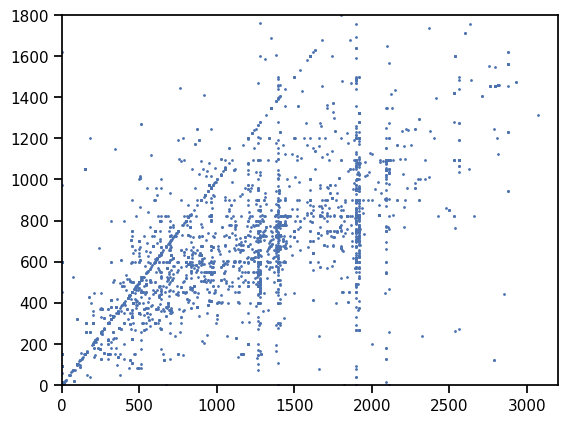

52

In [15]:
canvas_sizes = df_context['context-canvasSize'].dropna().to_list()
# plot the distribution of canvas size( as scatter plot)
plt.scatter([x[0] for x in canvas_sizes], [x[1] for x in canvas_sizes], s=1)
plt.xlim(0, 3200)
plt.ylim(0, 1800)
plt.show()
# count the canvas which size is larger than 3200x1800
len([x for x in canvas_sizes if x[0] > 3200 or x[1] > 1800])

In [16]:
import re
def remove_whitespaces(s: str):
    return re.sub(r'\s+', '', s)

In [17]:
remove_whitespaces("t est\nHelloworl d")

'testHelloworld'

In [18]:
df_program = expand_and_merge(df_context, 'context-programInfo', 'program-', explode=True)
df_program.reset_index(inplace=True)
df_program.index.name = 'index-program'
df_program

,index-context,index-url,url,category,duration,raf-accessTime,raf-rafFuncCountList,raf-title,raf-url,raf-usedOffScreenCanvas,...,context-memoryInfo-resources-sync,context-memoryInfo-resources-texture,context-memoryInfo-resources-transformFeedback,context-memoryInfo-resources-vertexArray,context-type,program-fragmentShaders,program-isDeleted,program-isLinked,program-useCounts,program-vertexShaders
index-program,,,,,,,,,,,,,,,,,,,,,
0,0,5,http://127.0.0.1:8000/test1/webgl/easy,[custom],30.827378,1681459501602,[2424],59.994 fps,http://127.0.0.1:8000/test1/webgl/easy,False,...,0.0,0,0.0,1.0,webgl2,[],False,False,2423,[]
1,0,5,http://127.0.0.1:8000/test1/webgl/easy,[custom],30.827378,1681459501602,[2424],59.994 fps,http://127.0.0.1:8000/test1/webgl/easy,False,...,0.0,0,0.0,1.0,webgl2,[#version 300 es\n#ifdef GL_ES\nprecision medi...,False,True,2424,[#version 300 es\n#ifdef GL_ES\nprecision medi...
2,1,6,http://127.0.0.1:8000/test1/webgl/hard,[custom],33.153617,1681459547533,[189],4.105 fps,http://127.0.0.1:8000/test1/webgl/hard,False,...,0.0,0,0.0,1.0,webgl2,[],False,False,188,[]
3,1,6,http://127.0.0.1:8000/test1/webgl/hard,[custom],33.153617,1681459547533,[189],4.105 fps,http://127.0.0.1:8000/test1/webgl/hard,False,...,0.0,0,0.0,1.0,webgl2,[#version 300 es\n#ifdef GL_ES\nprecision medi...,False,True,189,[#version 300 es\n#ifdef GL_ES\nprecision medi...
4,2,8,http://127.0.0.1:8000/test3/webgl/easy,[custom],30.765577,1681459634288,[2336],58.077 fps,http://127.0.0.1:8000/test3/webgl/easy,False,...,0.0,1,0.0,801.0,webgl2,[],False,False,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41561,13673,29238,https://map.e-zhetisu.kz/,['bq'],20.728770,1681839945180,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Геопортал области Жетісу,https://map.e-zhetisu.kz/,False,...,NaN,96,NaN,66.0,webgl,[#define HAS_UNIFORM_u_opacity\n#define HAS_UN...,False,True,46,[#define HAS_UNIFORM_u_opacity\n#define HAS_UN...
41562,13673,29238,https://map.e-zhetisu.kz/,['bq'],20.728770,1681839945180,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Геопортал области Жетісу,https://map.e-zhetisu.kz/,False,...,NaN,96,NaN,66.0,webgl,[#define HAS_UNIFORM_u_opacity\n#define HAS_UN...,False,True,46,[#define HAS_UNIFORM_u_opacity\n#define HAS_UN...
41563,13673,29238,https://map.e-zhetisu.kz/,['bq'],20.728770,1681839945180,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Геопортал области Жетісу,https://map.e-zhetisu.kz/,False,...,NaN,96,NaN,66.0,webgl,[#extension GL_OES_standard_derivatives : enab...,False,True,98,[\n #ifdef GL_ES\n precision highp float;\n ...


In [19]:
df_vert_shaders = pd.DataFrame({'shader_source': df_program['program-vertexShaders'].explode().explode(), 'shader_type': 'vertex'})
df_frag_shaders = pd.DataFrame({'shader_source': df_program['program-fragmentShaders'].explode().explode(), 'shader_type': 'fragment'})
df_shaders = df_program.drop(columns=['program-vertexShaders', 'program-fragmentShaders']).merge(pd.concat([df_vert_shaders, df_frag_shaders], ignore_index=False), left_index=True, right_index=True)
df_shaders.dropna(subset=['shader_source'], inplace=True)
df_shaders.reset_index(inplace=True)
df_shaders.index.name = 'index-shader'
df_shaders['shader_length'] = df_shaders['shader_source'].str.len()

assert (df_shaders['shader_source'].apply(lambda x: type(x)) == str).all()
# df_shaders[df_shaders['shader_source'].apply(lambda x: type(x)) != str]

# Flatten ContextInfos

In [20]:
# # fcontext_infos = [flatten_ctx_info(x) for x in context_infos]
# fcontext_infos = []
# fdf_columns = set()
# for x in context_infos:
#     fcontext_infos.append(flatten_ctx_info(x))
#     fdf_columns.update(flatten_ctx_info(x).keys())

# fdf = pd.DataFrame(fcontext_infos)
# # zip column name with dtype
# for x in fdf.columns.tolist():
#     print(x, fdf[x].dtype)

In [21]:
# fdf.fillna(0, inplace=True)
# print((len(fdf[fdf['total_func_call'] == 0])))
# fdf_url = fdf.groupby('url').aggregate(np.sum)
# fdf = fdf[fdf['total_func_call'] > 0]
# fdf_url[fdf_url['total_func_call'] == 0].to_csv(OUT_PATH / 'total_func_call_0.csv')
# fdf_url[fdf_url['shader_count'] == 0].to_csv(OUT_PATH / 'shader_count_0.csv')
# fdf_url[fdf_url['program_count'] == 1].to_csv(OUT_PATH / 'program_count_1.csv')
# fdf_url[fdf_url['_memory_total'] == 0].to_csv(OUT_PATH / '_memory_total_0.csv')
# fdf_url = fdf_url[fdf_url['total_func_call'] > 0]
# fdf

In [22]:
# len(fdf.url.unique())

# Context Type

In [23]:
df_shaders.dtypes.to_dict()

{'index-program': dtype('int64'),
 'index-context': dtype('int64'),
 'index-url': Int64Dtype(),
 'url': dtype('O'),
 'category': dtype('O'),
 'duration': dtype('float64'),
 'raf-accessTime': dtype('int64'),
 'raf-rafFuncCountList': dtype('O'),
 'raf-title': dtype('O'),
 'raf-url': dtype('O'),
 'raf-usedOffScreenCanvas': dtype('bool'),
 'raf-when': dtype('float64'),
 'raf-whenDomContentLoadedEvent': dtype('float64'),
 'raf-whenLoadEvent': dtype('float64'),
 'raf-whenUsedWebgl': dtype('float64'),
 'context-canvasContained': dtype('bool'),
 'context-canvasHidden': dtype('bool'),
 'context-canvasSize': dtype('O'),
 'context-capturedFunctionsLength': dtype('int64'),
 'context-extensions': dtype('O'),
 'context-triangleCount': dtype('O'),
 'context-vertexCount': dtype('float64'),
 'context-contextAttributes-alpha': dtype('bool'),
 'context-contextAttributes-antialias': dtype('bool'),
 'context-contextAttributes-depth': dtype('bool'),
 'context-contextAttributes-desynchronized': dtype('bool')

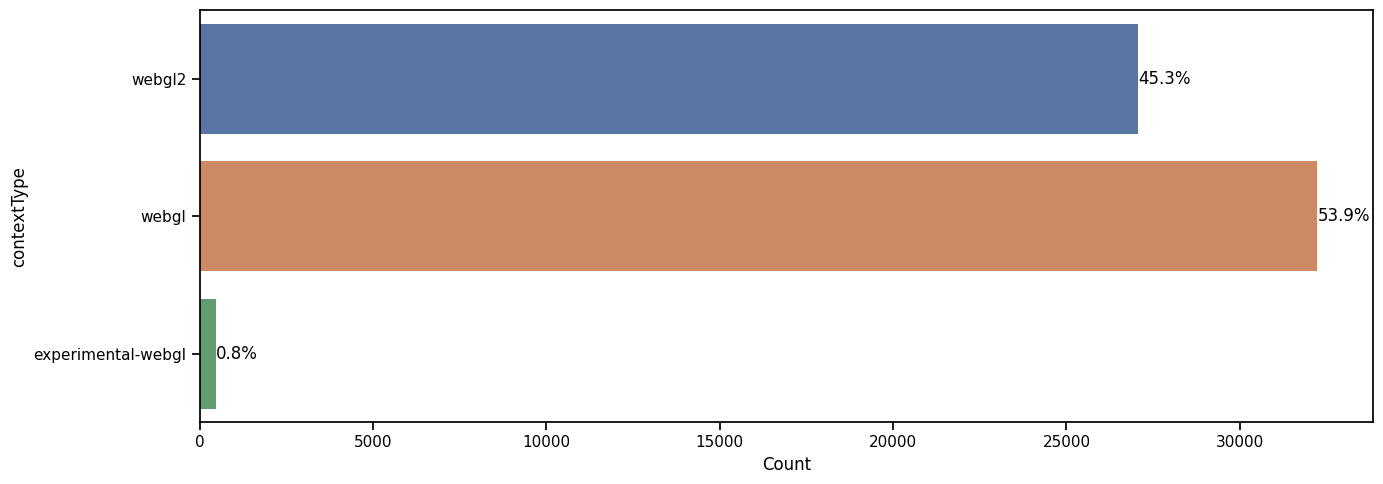

In [24]:
fig, axes = plt.subplots(figsize=(14, 5))

sns.countplot(y='context-type', data=df_shaders, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('contextType')

for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(df_shaders)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')

plt.tight_layout()
plt.show()

# Power Preference

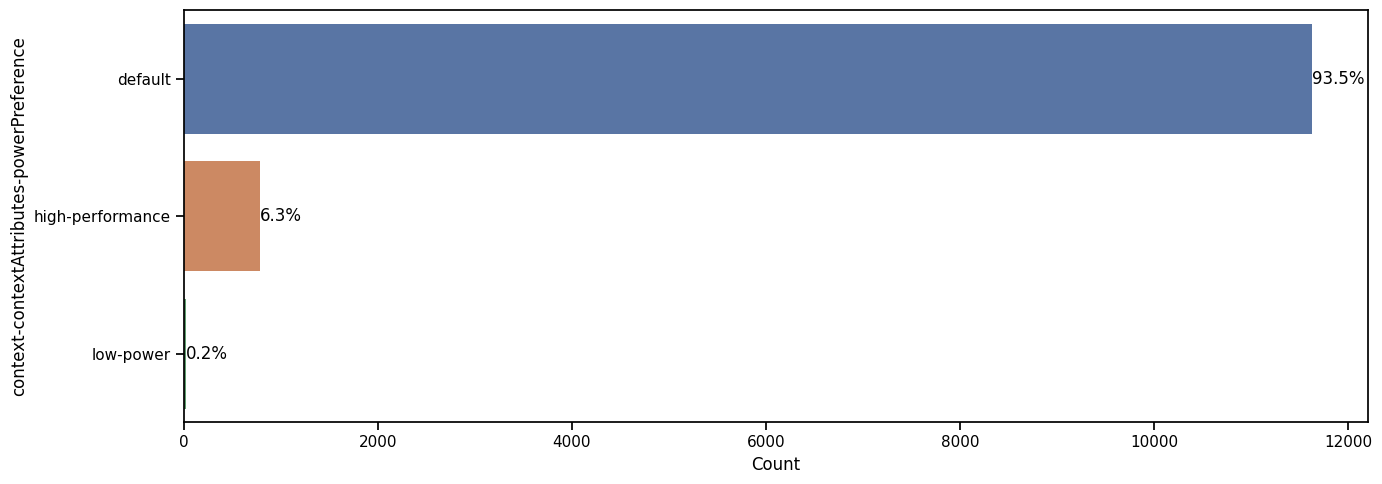

In [25]:
fig, axes = plt.subplots(figsize=(14, 5))

sns.countplot(y='context-contextAttributes-powerPreference', data=df_context, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('context-contextAttributes-powerPreference')

for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(df_context)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')

plt.tight_layout()
plt.show()

# Context Attrib

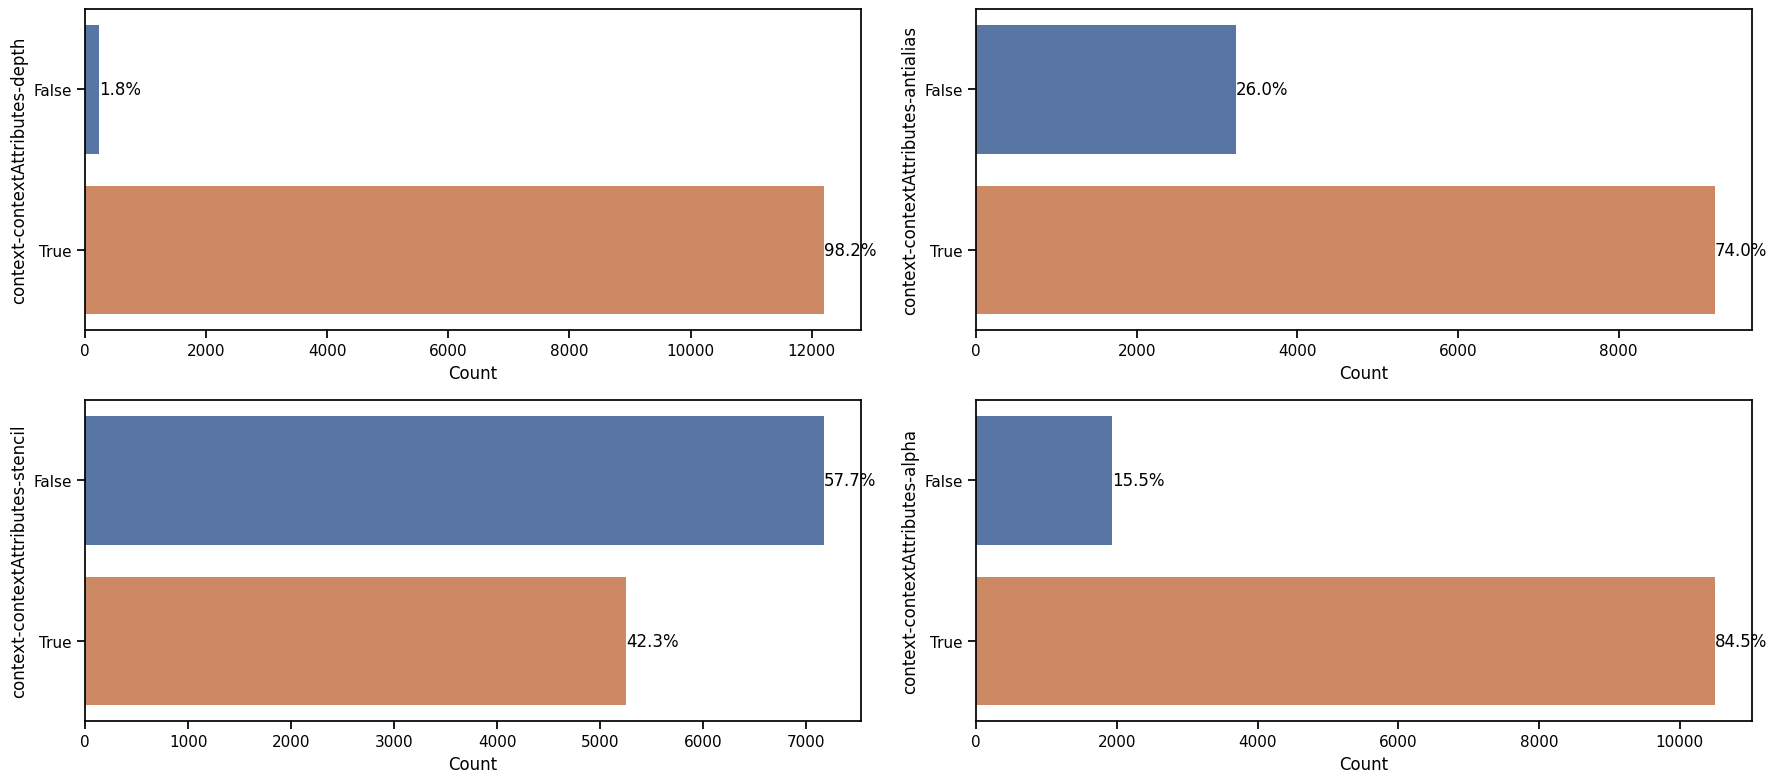

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))

sns.countplot(y='context-contextAttributes-depth', data=df_context, ax=axes[0,0])
axes[0,0].set_xlabel('Count')
axes[0,0].set_ylabel('context-contextAttributes-depth')

sns.countplot(y='context-contextAttributes-antialias', data=df_context, ax=axes[0,1])
axes[0,1].set_xlabel('Count')
axes[0,1].set_ylabel('context-contextAttributes-antialias')

sns.countplot(y='context-contextAttributes-stencil', data=df_context, ax=axes[1,0])
axes[1,0].set_xlabel('Count')
axes[1,0].set_ylabel('context-contextAttributes-stencil')

sns.countplot(y='context-contextAttributes-alpha', data=df_context, ax=axes[1,1])
axes[1,1].set_xlabel('Count')
axes[1,1].set_ylabel('context-contextAttributes-alpha')

for x in range(2):
    for y in range(2):
        for rect in axes[x,y].patches:
            axes[x,y].annotate(f'{rect.get_width()/len(df_context)*100:.1f}%', 
                                (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                                ha='left', va='center')

plt.tight_layout()
plt.show()

In [27]:
# (fdf.when - fdf.whenUsedWebgl).describe()

# Extensions

In [28]:
tmp = df_context['context-extensions'].apply(len)
print("percentage of context which has no extension: {:.2f}%".format((tmp == 0).sum() / len(tmp) * 100))

percentage of context which has no extension: 42.10%


In [29]:
with open('input/webgl-extension-categories.json', 'r') as fp:
    category_to_extension = json.load(fp)

extension_to_category = defaultdict(lambda: 'unknown')
for category, extensions in category_to_extension.items():
    for extension in extensions:
        extension_to_category[extension] = category

In [30]:
extension_to_category['42']

'unknown'

count                          7197
unique                          360
top       WEBGL_debug_renderer_info
freq                            792
Name: context-extensions, dtype: object


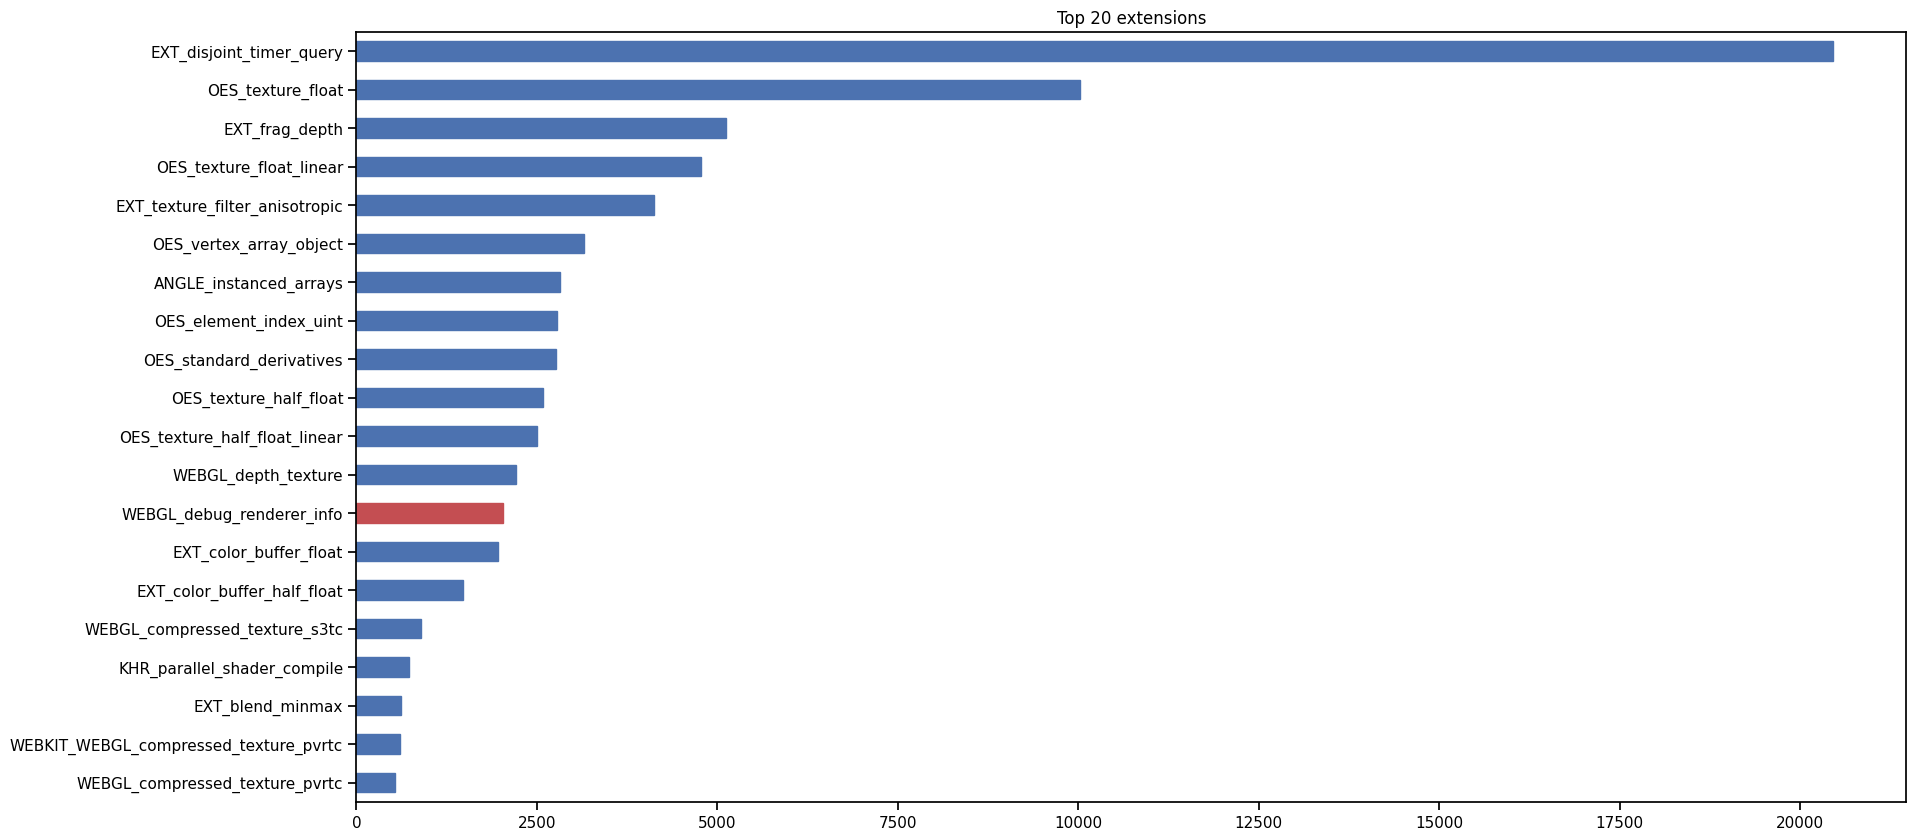

In [31]:
extension = df_context[df_context['context-extensions'].apply(len) > 0]['context-extensions']
tmp = extension.apply(lambda x: ';'.join(x)).value_counts().to_dict()
json.dump(tmp, open(OUT_PATH / 'example' / 'extension-count.json', 'w'), indent=2)
tmp2 = extension.apply(lambda x: ';'.join(x)).describe()
print(tmp2)
words_list = tmp2['top'].split(';')
tmp2 = []
for lst in extension:
    tmp2.extend(lst)

extension_df = pd.DataFrame({
    'name': pd.Series(tmp2),
    'category': pd.Series([extension_to_category[x] for x in tmp2]),
    'prefix': pd.Series([x.split('_')[0] for x in tmp2])
})
extension_df = extension_df[(extension_df['prefix'].str.len() > 2) & (extension_df['prefix'].str.upper() == extension_df['prefix'])]

tmp = extension_df['name'].value_counts(ascending=True)
# print(tmp.to_dict())
to_plot = tmp.iloc[len(tmp)-20:]
bar = to_plot.plot.barh(figsize=(20, 10))
for i, v in enumerate(to_plot.index):
    if v in words_list:
        bar.get_children()[i].set_color(sns.color_palette()[3])
    else:
        bar.get_children()[i].set_color(sns.color_palette()[0])
plt.title('Top 20 extensions')
plt.show()

In [32]:
sorted(set(extension_df[extension_df['category'] == 'unknown'].name))

['EXT_draw_buffers',
 'EXT_multisampled_render_to_texture',
 'GMAN_webgl_memory',
 'MOZ_EXT_texture_filter_anisotropic',
 'MOZ_OES_texture_half_float_linear',
 'MOZ_OES_vertex_array_object',
 'MOZ_WEBGL_compressed_texture_astc',
 'MOZ_WEBGL_compressed_texture_atc',
 'MOZ_WEBGL_compressed_texture_etc',
 'MOZ_WEBGL_compressed_texture_etc1',
 'MOZ_WEBGL_compressed_texture_pvrtc',
 'MOZ_WEBGL_depth_texture',
 'NVX_gpu_memory_info',
 'OCULUS_multiview',
 'OES_float_linear',
 'OES_seamless_cube_map',
 'WEBGL_compressed_texture_bptc',
 'WEBGL_compressed_texture_es3_0',
 'WEBGL_compressed_texture_rgtc',
 'WEBGL_multisampled_render_to_texture',
 'WEBG_compressed_texture_etc',
 'WEBKIT_EXT_texture_filter_anisotropic',
 'WEBKIT_OES_texture_half_float_linear',
 'WEBKIT_OES_vertex_array_object',
 'WEBKIT_WEBGL_compressed_texture_astc',
 'WEBKIT_WEBGL_compressed_texture_atc',
 'WEBKIT_WEBGL_compressed_texture_bptc',
 'WEBKIT_WEBGL_compressed_texture_etc',
 'WEBKIT_WEBGL_compressed_texture_etc1',
 'W

In [33]:
extension_df['category'].value_counts()

Khronos ratified WebGL Extensions      47335
Community approved WebGL Extensions    28242
unknown                                 2178
Rejected WebGL Extensions                247
Draft WebGL Extensions                    30
Name: category, dtype: int64

## Extension 开发过程

Extension 在其发展过程中经历了四个阶段：建议、草案、社区批准和Khronos批准。每个 extension 都应该推进到Khronos的批准。如果一个 extension 不能通过 extension 过程来推进，它可以被拒绝。

- Proposed extensions 是为了在公共WebGL邮件列表中进行讨论，以便进入草案状态；它们不应该被实现，即使是在供应商的前缀下。如果在社区中达成了共识，该 extension 就可以转为草案状态。
- Draft extensions 可以在供应商的前缀下实现，或者在运行时选项后面实现，以达到实验的目的，以便在最终确定 extension 之前获得经验。草案 extension 不应默认由WebGL实现来公开。一旦在社区中达成共识，该 extension 就可以转为Community approved 状态。
- Community approved extensions 应该在没有供应商前缀的情况下实现。当一个 extension 草案转为社区认可状态时，任何现有的实现都应该立即取消对任何厂商前缀的 extension 名称的支持。一旦被厂商实现，除非该 extension 存在严重问题，如安全漏洞，否则不应取消支持。
- Khronos ratified extensions 是那些经过Khronos委员会投票通过的Community approved extension 。
- Rejected extensions（不应被实现）。扩展进入被拒绝状态是因为在提议阶段没有达成共识或在草案阶段实施过程中出现技术困难。只有在特殊情况下，社区批准的扩展才能被拒绝。Khronos认可的扩展不能被拒绝。

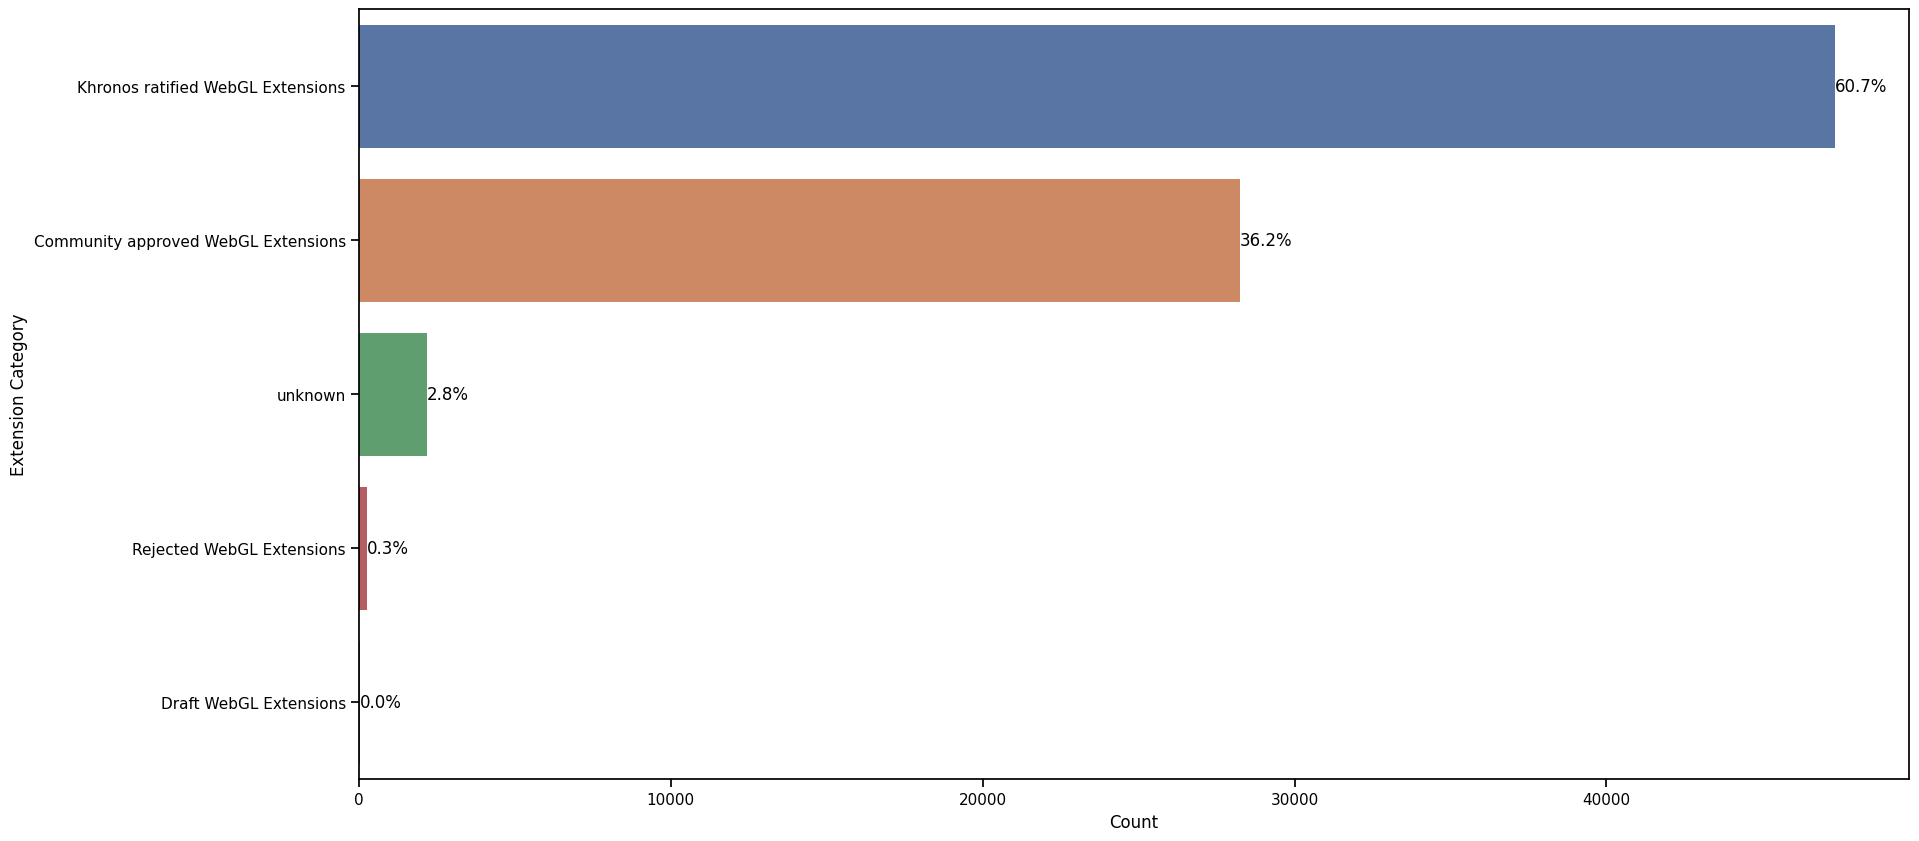

In [34]:
# extension_category.value_counts().plot.barh(figsize=(20, 10))
# with percentage
fig, axes = plt.subplots(figsize=(20, 10))
sns.countplot(y=extension_df['category'], ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('Extension Category')
for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(extension_df)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')
plt.show()


## 命名约定

WebGL 扩展以“ANGLE”、“OES”、“EXT”、“WEBGL”等为前缀。这些前缀反映了来源和意图：

- `ANGLE_`: 由 ANGLE library 的作者编写的扩展。
- `OES_` 和 `KHR_`: 由各自的架构审查委员会（Khronos）批准的对 OpenGL ES（OES）或 OpenGL API 扩展的功能的镜像。
- `OVR_`: 针对虚拟现实进行优化的扩展。
- `EXT_`: 从其他 OpenGL ES 或 OpenGL API 扩展镜像的扩展。
- `WEBGL_`: 特定于 WebGL 的扩展，旨在与多种 Web 浏览器兼容。它也应该用于源自 OpenGL ES 或 OpenGL API 的扩展，但其行为已被显著改变。

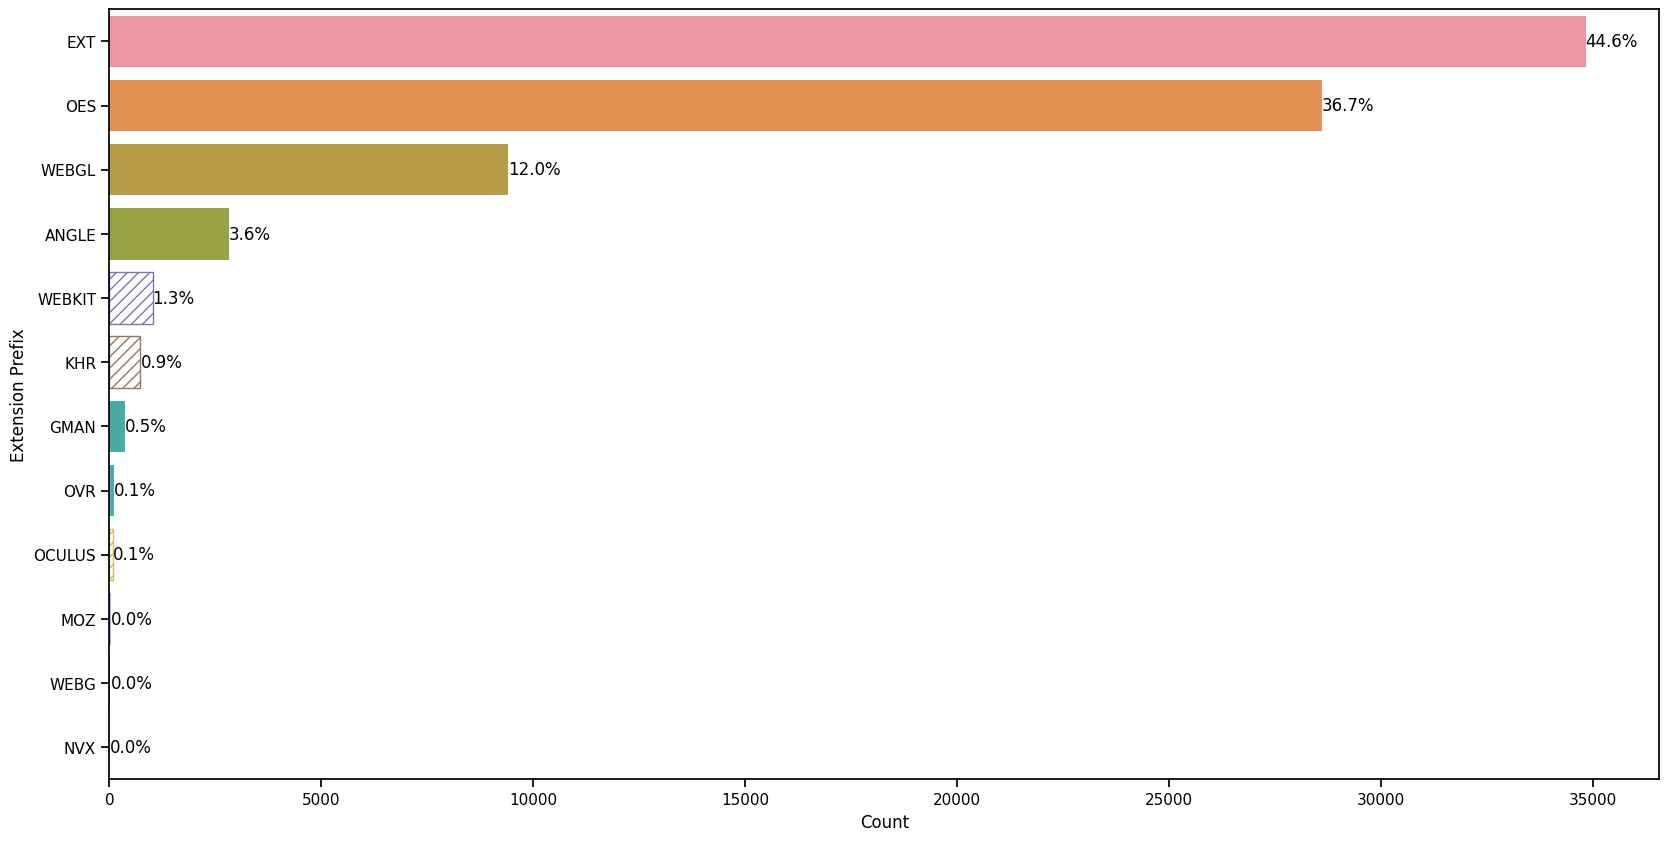

In [35]:
# extension_category.value_counts().plot.barh(figsize=(20, 10))
# with percentage
fig, axes = plt.subplots(figsize=(20, 10))
sns.countplot(y=extension_df['prefix'], ax=axes, order=extension_df['prefix'].value_counts().index)
axes.set_xlabel('Count')
axes.set_ylabel('Extension Prefix')
for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(extension_df)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')
# hatch='///' on MOZ WEBKIT OCULUS
for i in [4,5,8]:
    axes.patches[i].set_hatch('///')
    axes.patches[i].set_facecolor('white')
    axes.patches[i].set_edgecolor(color_palette[i])
plt.show()

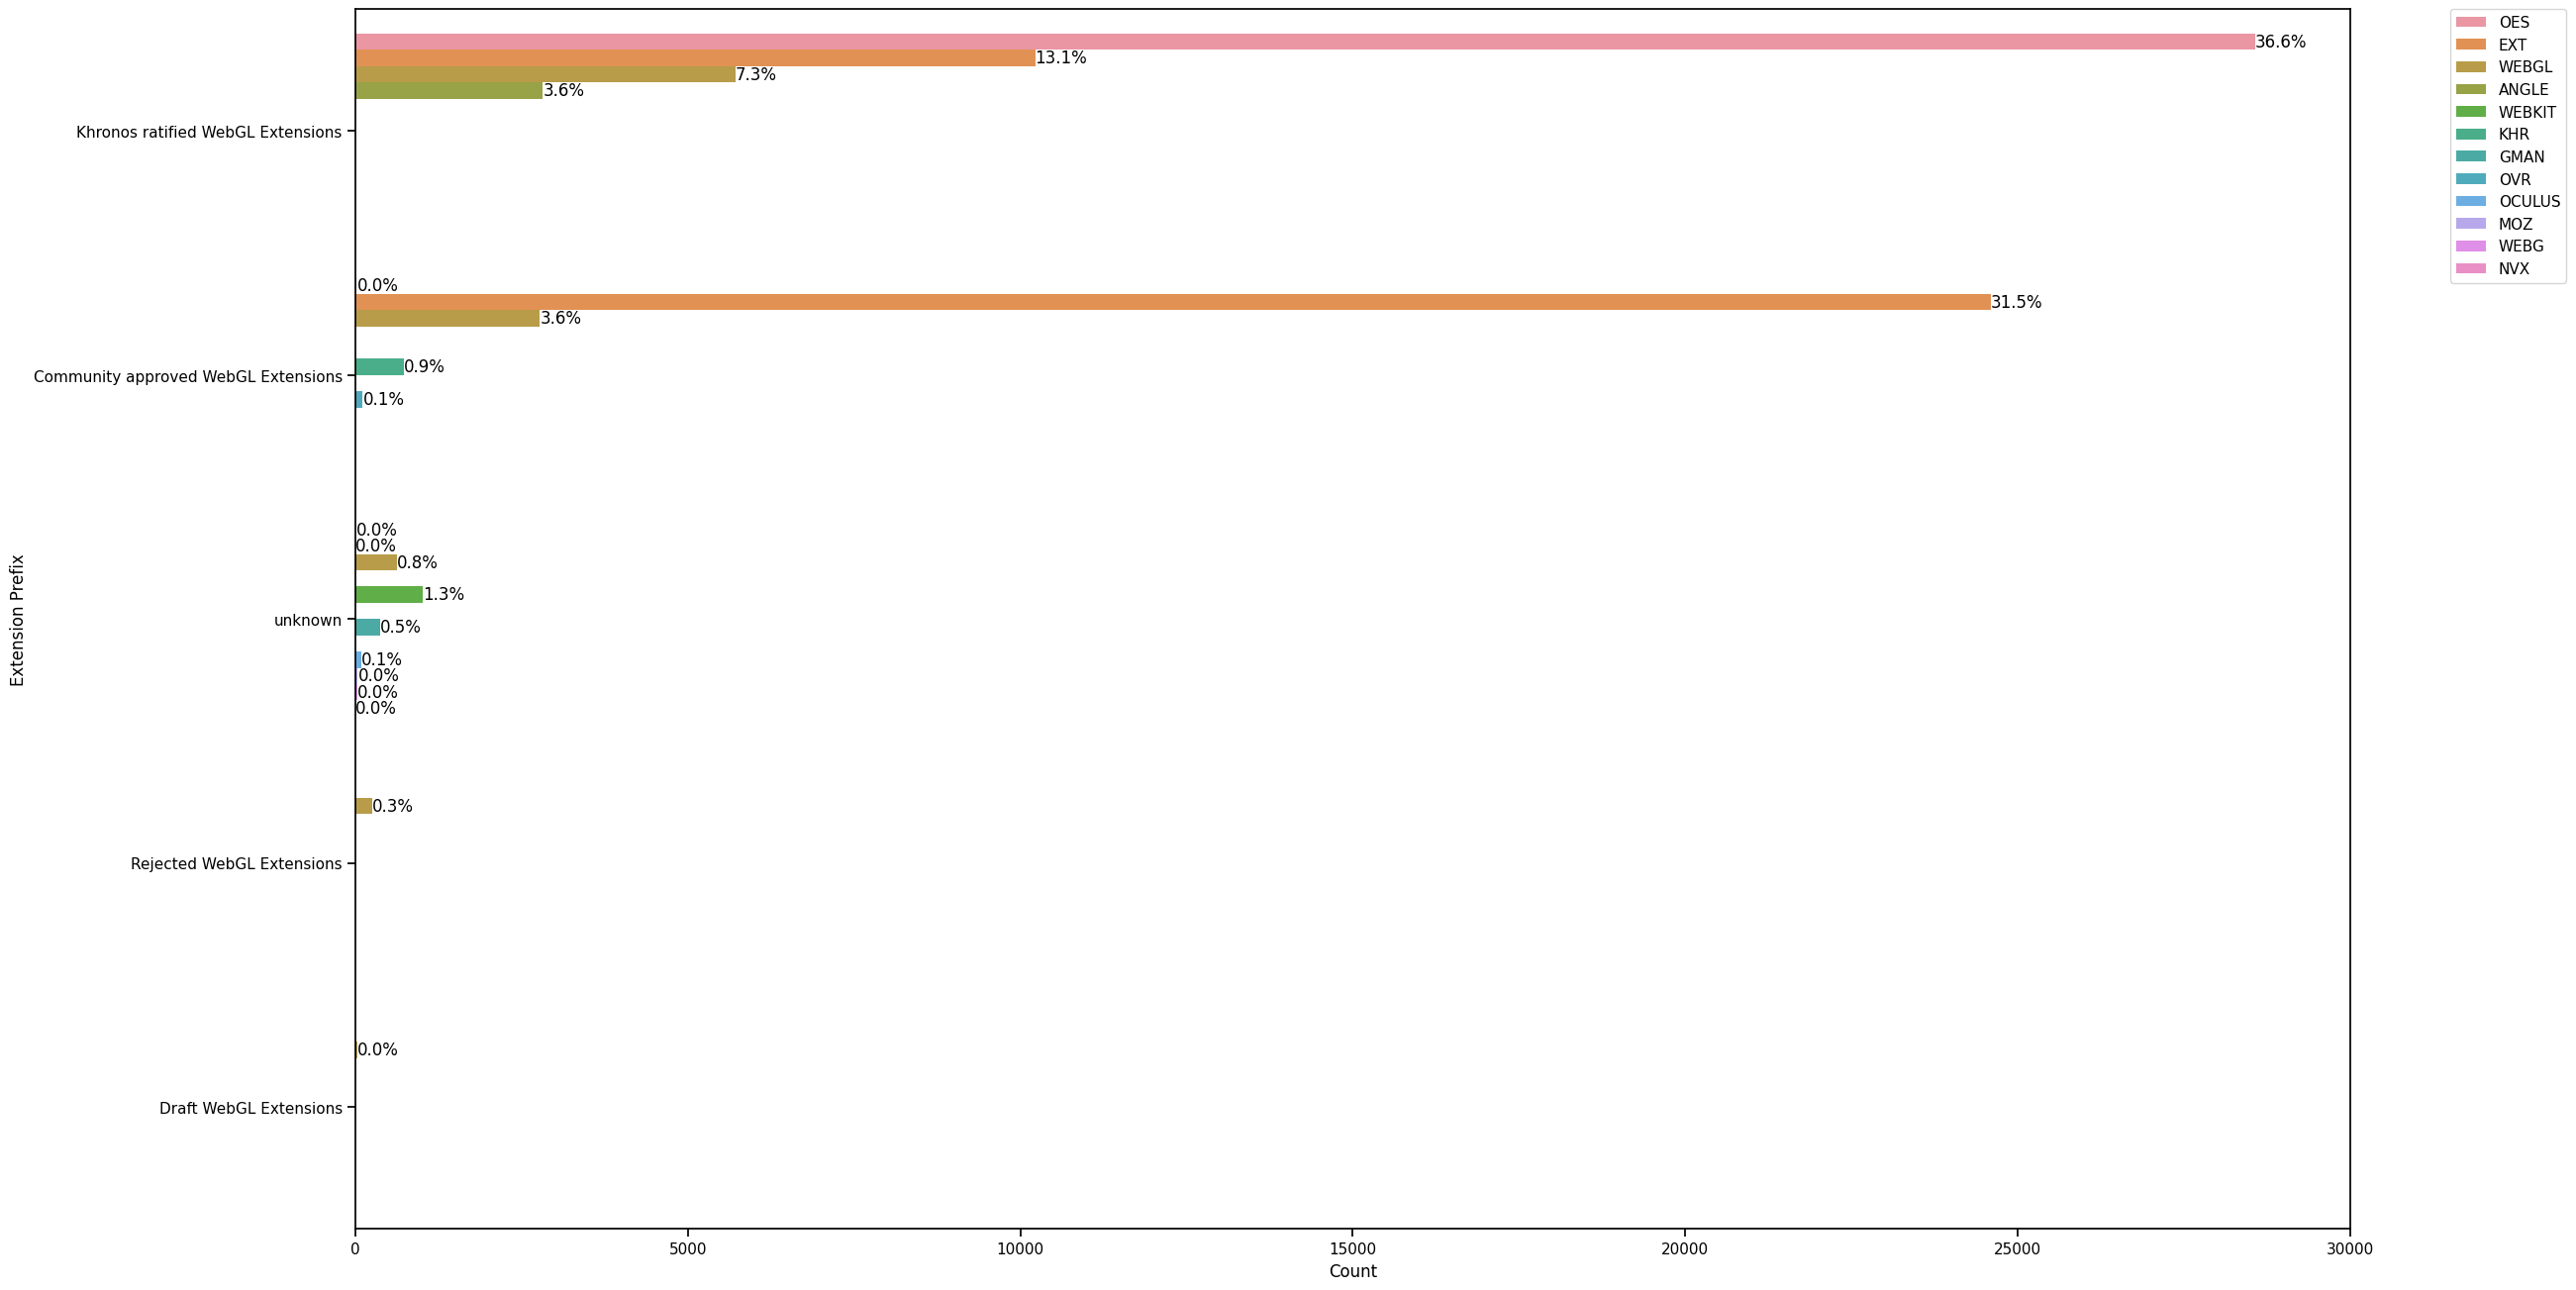

In [36]:
fig, axes = plt.subplots(figsize=(26, 16))
tmp = extension_df.value_counts(subset=['prefix', 'category'])
tmp = tmp.reset_index()
tmp.columns = ['prefix', 'category', 'count']
tmp
sns.barplot(x='count', y='category', hue='prefix', data=tmp, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('Extension Prefix')
for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(extension_df)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [37]:
# tmp = extension.apply(lambda x: ';'.join(x))
# df_context[df_context.extensions.apply(len) > 0][tmp.str.contains('BdwhLT1F')]

In [38]:
# extension.describe()

# WebGL calls

In [39]:
total_func_call = pd.DataFrame(df_context['context-maghsk-counter-funcCount'].to_list(), index=df_context.index).sum(axis=1)

count    1.242900e+04
mean     2.523929e+05
std      2.140296e+06
min      0.000000e+00
50%      4.300000e+01
75%      2.664300e+04
90%      2.668314e+05
95%      9.826950e+05
99%      4.716824e+06
max      1.230075e+08
dtype: float64


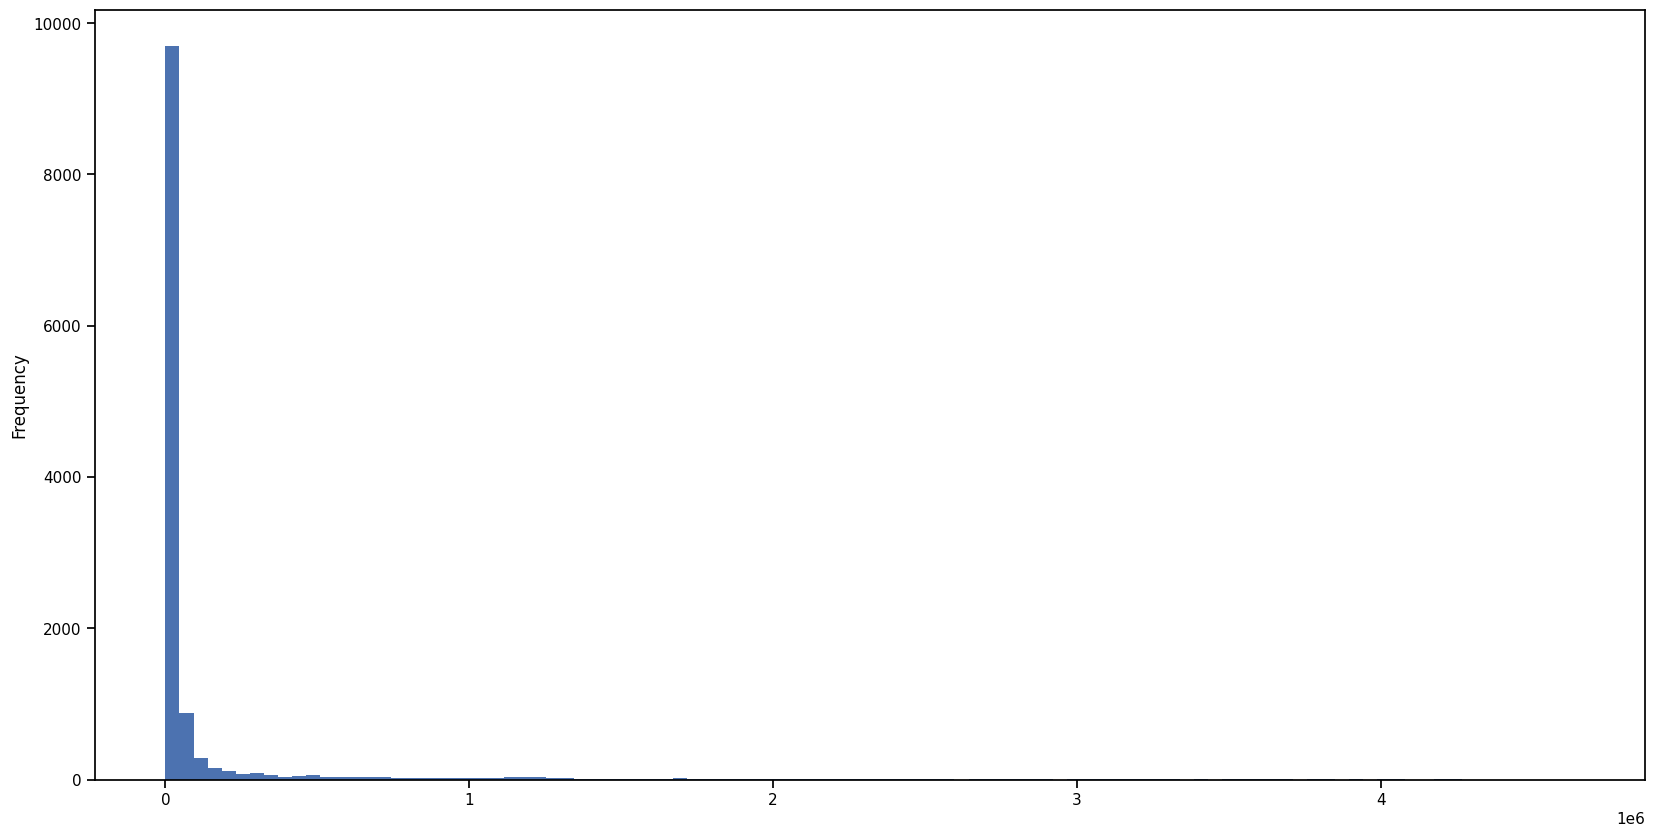

In [40]:
print(total_func_call.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
# df_context[total_func_call < 100].total_func_call.value_counts().sort_index().plot(kind='bar', figsize=(20, 10))
total_func_call[total_func_call < total_func_call.quantile(0.99)].plot(kind='hist', bins=100, figsize=(20, 10))
plt.show()

# shader!

In [41]:
df_shaders

,index-program,index-context,index-url,url,category,duration,raf-accessTime,raf-rafFuncCountList,raf-title,raf-url,...,context-memoryInfo-resources-texture,context-memoryInfo-resources-transformFeedback,context-memoryInfo-resources-vertexArray,context-type,program-isDeleted,program-isLinked,program-useCounts,shader_source,shader_type,shader_length
index-shader,,,,,,,,,,,,,,,,,,,,,
0,1,0,5,http://127.0.0.1:8000/test1/webgl/easy,[custom],30.827378,1681459501602,[2424],59.994 fps,http://127.0.0.1:8000/test1/webgl/easy,...,0,0.0,1.0,webgl2,False,True,2424,#version 300 es\n#ifdef GL_ES\nprecision mediu...,vertex,285
1,1,0,5,http://127.0.0.1:8000/test1/webgl/easy,[custom],30.827378,1681459501602,[2424],59.994 fps,http://127.0.0.1:8000/test1/webgl/easy,...,0,0.0,1.0,webgl2,False,True,2424,#version 300 es\n#ifdef GL_ES\nprecision mediu...,fragment,132
2,3,1,6,http://127.0.0.1:8000/test1/webgl/hard,[custom],33.153617,1681459547533,[189],4.105 fps,http://127.0.0.1:8000/test1/webgl/hard,...,0,0.0,1.0,webgl2,False,True,189,#version 300 es\n#ifdef GL_ES\nprecision mediu...,vertex,285
3,3,1,6,http://127.0.0.1:8000/test1/webgl/hard,[custom],33.153617,1681459547533,[189],4.105 fps,http://127.0.0.1:8000/test1/webgl/hard,...,0,0.0,1.0,webgl2,False,True,189,#version 300 es\n#ifdef GL_ES\nprecision mediu...,fragment,132
4,5,2,8,http://127.0.0.1:8000/test3/webgl/easy,[custom],30.765577,1681459634288,[2336],58.077 fps,http://127.0.0.1:8000/test3/webgl/easy,...,1,0.0,801.0,webgl2,False,True,2335,#version 300 es\n#ifdef GL_ES\nprecision mediu...,vertex,243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59755,41563,13673,29238,https://map.e-zhetisu.kz/,['bq'],20.728770,1681839945180,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Геопортал области Жетісу,https://map.e-zhetisu.kz/,...,96,NaN,66.0,webgl,False,True,98,#extension GL_OES_standard_derivatives : enabl...,fragment,3607
59756,41564,13673,29238,https://map.e-zhetisu.kz/,['bq'],20.728770,1681839945180,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Геопортал области Жетісу,https://map.e-zhetisu.kz/,...,96,NaN,66.0,webgl,False,True,81,#define HAS_UNIFORM_u_fill_color\n#define HAS_...,vertex,15154
59757,41564,13673,29238,https://map.e-zhetisu.kz/,['bq'],20.728770,1681839945180,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Геопортал области Жетісу,https://map.e-zhetisu.kz/,...,96,NaN,66.0,webgl,False,True,81,#define HAS_UNIFORM_u_fill_color\n#define HAS_...,fragment,5715


In [42]:
tmp = OUT_PATH / 'example' / 'sampled_shaders'
for index_shader, row in df_shaders.sample(10).iterrows():
    shader = row.shader_source
    typ = row.shader_type
    index_url = row['index-url']
    index_context = row['index-context']
    index_program = row['index-program']
    with open(tmp / f'{index_url}-{index_context}-{index_program}-{index_shader}.{typ}', 'w') as f:
        f.write(shader)

## Diversity of shaders

In [43]:
import hashlib

In [44]:
df_shaders_trim = df_shaders
df_shaders_trim['shader_source_trimmed_hashed'] = df_shaders_trim['shader_source'].apply(lambda x: hashlib.sha256(remove_whitespaces(x).encode('utf-8')).hexdigest())
df_shaders_trim

,index-program,index-context,index-url,url,category,duration,raf-accessTime,raf-rafFuncCountList,raf-title,raf-url,...,context-memoryInfo-resources-transformFeedback,context-memoryInfo-resources-vertexArray,context-type,program-isDeleted,program-isLinked,program-useCounts,shader_source,shader_type,shader_length,shader_source_trimmed_hashed
index-shader,,,,,,,,,,,,,,,,,,,,,
0,1,0,5,http://127.0.0.1:8000/test1/webgl/easy,[custom],30.827378,1681459501602,[2424],59.994 fps,http://127.0.0.1:8000/test1/webgl/easy,...,0.0,1.0,webgl2,False,True,2424,#version 300 es\n#ifdef GL_ES\nprecision mediu...,vertex,285,54f5ab1e8fa444d540f4eb64b68c5b6e4df8998f208518...
1,1,0,5,http://127.0.0.1:8000/test1/webgl/easy,[custom],30.827378,1681459501602,[2424],59.994 fps,http://127.0.0.1:8000/test1/webgl/easy,...,0.0,1.0,webgl2,False,True,2424,#version 300 es\n#ifdef GL_ES\nprecision mediu...,fragment,132,161c2a26d6c34ecee5147cc69beebb3cd50f40914a1423...
2,3,1,6,http://127.0.0.1:8000/test1/webgl/hard,[custom],33.153617,1681459547533,[189],4.105 fps,http://127.0.0.1:8000/test1/webgl/hard,...,0.0,1.0,webgl2,False,True,189,#version 300 es\n#ifdef GL_ES\nprecision mediu...,vertex,285,54f5ab1e8fa444d540f4eb64b68c5b6e4df8998f208518...
3,3,1,6,http://127.0.0.1:8000/test1/webgl/hard,[custom],33.153617,1681459547533,[189],4.105 fps,http://127.0.0.1:8000/test1/webgl/hard,...,0.0,1.0,webgl2,False,True,189,#version 300 es\n#ifdef GL_ES\nprecision mediu...,fragment,132,161c2a26d6c34ecee5147cc69beebb3cd50f40914a1423...
4,5,2,8,http://127.0.0.1:8000/test3/webgl/easy,[custom],30.765577,1681459634288,[2336],58.077 fps,http://127.0.0.1:8000/test3/webgl/easy,...,0.0,801.0,webgl2,False,True,2335,#version 300 es\n#ifdef GL_ES\nprecision mediu...,vertex,243,6d9cb76afc5d1efcc48b0ee1e06fb941975cc0cc1fbb02...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59755,41563,13673,29238,https://map.e-zhetisu.kz/,['bq'],20.728770,1681839945180,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Геопортал области Жетісу,https://map.e-zhetisu.kz/,...,NaN,66.0,webgl,False,True,98,#extension GL_OES_standard_derivatives : enabl...,fragment,3607,7d3f9e13b3b11eb1d78a1df456e8195daae69ebf8d630e...
59756,41564,13673,29238,https://map.e-zhetisu.kz/,['bq'],20.728770,1681839945180,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Геопортал области Жетісу,https://map.e-zhetisu.kz/,...,NaN,66.0,webgl,False,True,81,#define HAS_UNIFORM_u_fill_color\n#define HAS_...,vertex,15154,aa3b49f6d5254c4a3ac3ad1dade792e6559ccbbc75c22e...
59757,41564,13673,29238,https://map.e-zhetisu.kz/,['bq'],20.728770,1681839945180,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Геопортал области Жетісу,https://map.e-zhetisu.kz/,...,NaN,66.0,webgl,False,True,81,#define HAS_UNIFORM_u_fill_color\n#define HAS_...,fragment,5715,9c90e08c35f3732722d76347c72ee093df80decf4d66e3...


### Context Level

In [45]:
# group by source and count the different urls
df_source_count = df_shaders_trim.groupby('shader_source_trimmed_hashed')[['index-program','index-context','index-url']].nunique()
tmp = df_shaders_trim.set_index('shader_source_trimmed_hashed')[['shader_type','shader_source','shader_length']]
tmp = tmp[~tmp.index.duplicated(keep='first')]
df_source_count = df_source_count.join(tmp, how='inner')
df_source_count.reset_index(inplace=True)
df_source_count.index.name = 'index-source'
df_source_count

,shader_source_trimmed_hashed,index-program,index-context,index-url,shader_type,shader_source,shader_length
index-source,,,,,,,
0,000b92a60950d1c172ce9f6ca983d9e19295d6c3810613...,89,89,89,vertex,#ifdef GL_FRAGMENT_PRECISION_HIGH\nprecision h...,345
1,000bfbfe6e9d0cbe0ee0b5df0e65a8db25b9ddf64edee2...,1,1,1,vertex,precision highp float;\nprecision highp int;\n...,10587
2,0017890e4b0c9597659fff1ed5a8f81dc95d9d2a274a73...,2,1,1,vertex,#version 300 es\nprecision mediump sampler2DAr...,12901
3,0017f7b3f89c37f75050d17a6e85ba7dbb7b4aee9ec3c4...,1,1,1,fragment,#version 300 es\n#define varying in\nlayout(lo...,53582
4,00181baed9522beba99b3a65c1dfa6b948851119982a6a...,1,1,1,fragment,#version 300 es\n#define varying in\nlayout(lo...,12497
...,...,...,...,...,...,...,...
19767,fff16ca09aa4dffd93e37aba05944704b20bf7b628631b...,5,5,5,vertex,precision highp float;\nattribute vec2 aVertex...,403
19768,fff307406cb0f50c3f5323bee0c9cc1e12b8be53c95099...,2,2,2,fragment,#version 300 es\n\n\n\nprecision highp float;\...,537
19769,fff516a7602ff50b224940cda7b7a0f156bf41f19e2c7d...,1,1,1,fragment,#version 300 es\n\n\n\n\nprecision highp float...,12450


In [46]:
df_source_count[['index-program','index-context','index-url']].sum(axis=0)

index-program    58388
index-context    47816
index-url        43194
dtype: int64

<Axes: title={'center': 'By context'}, xlabel='index-source', ylabel='Number of Contexts'>

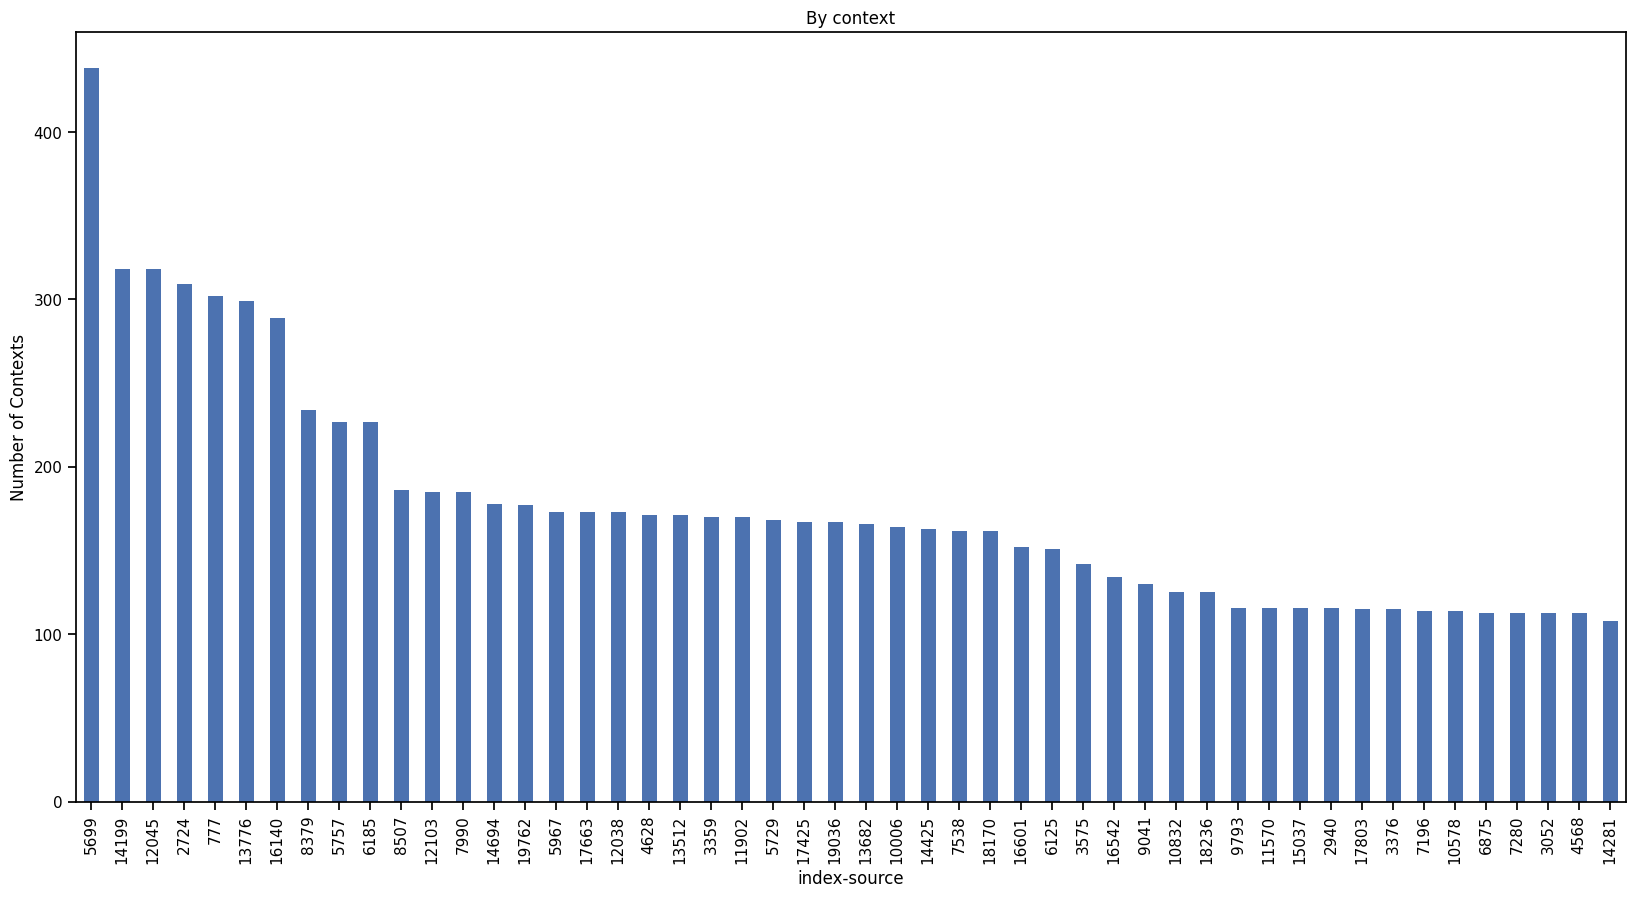

In [47]:
plt.title("By context")
plt.xlabel('Shader ID')
plt.ylabel('Number of Contexts')
df_source_count.sort_values('index-context', ascending=False).head(50)['index-context'].plot(kind='bar', figsize=(20, 10))


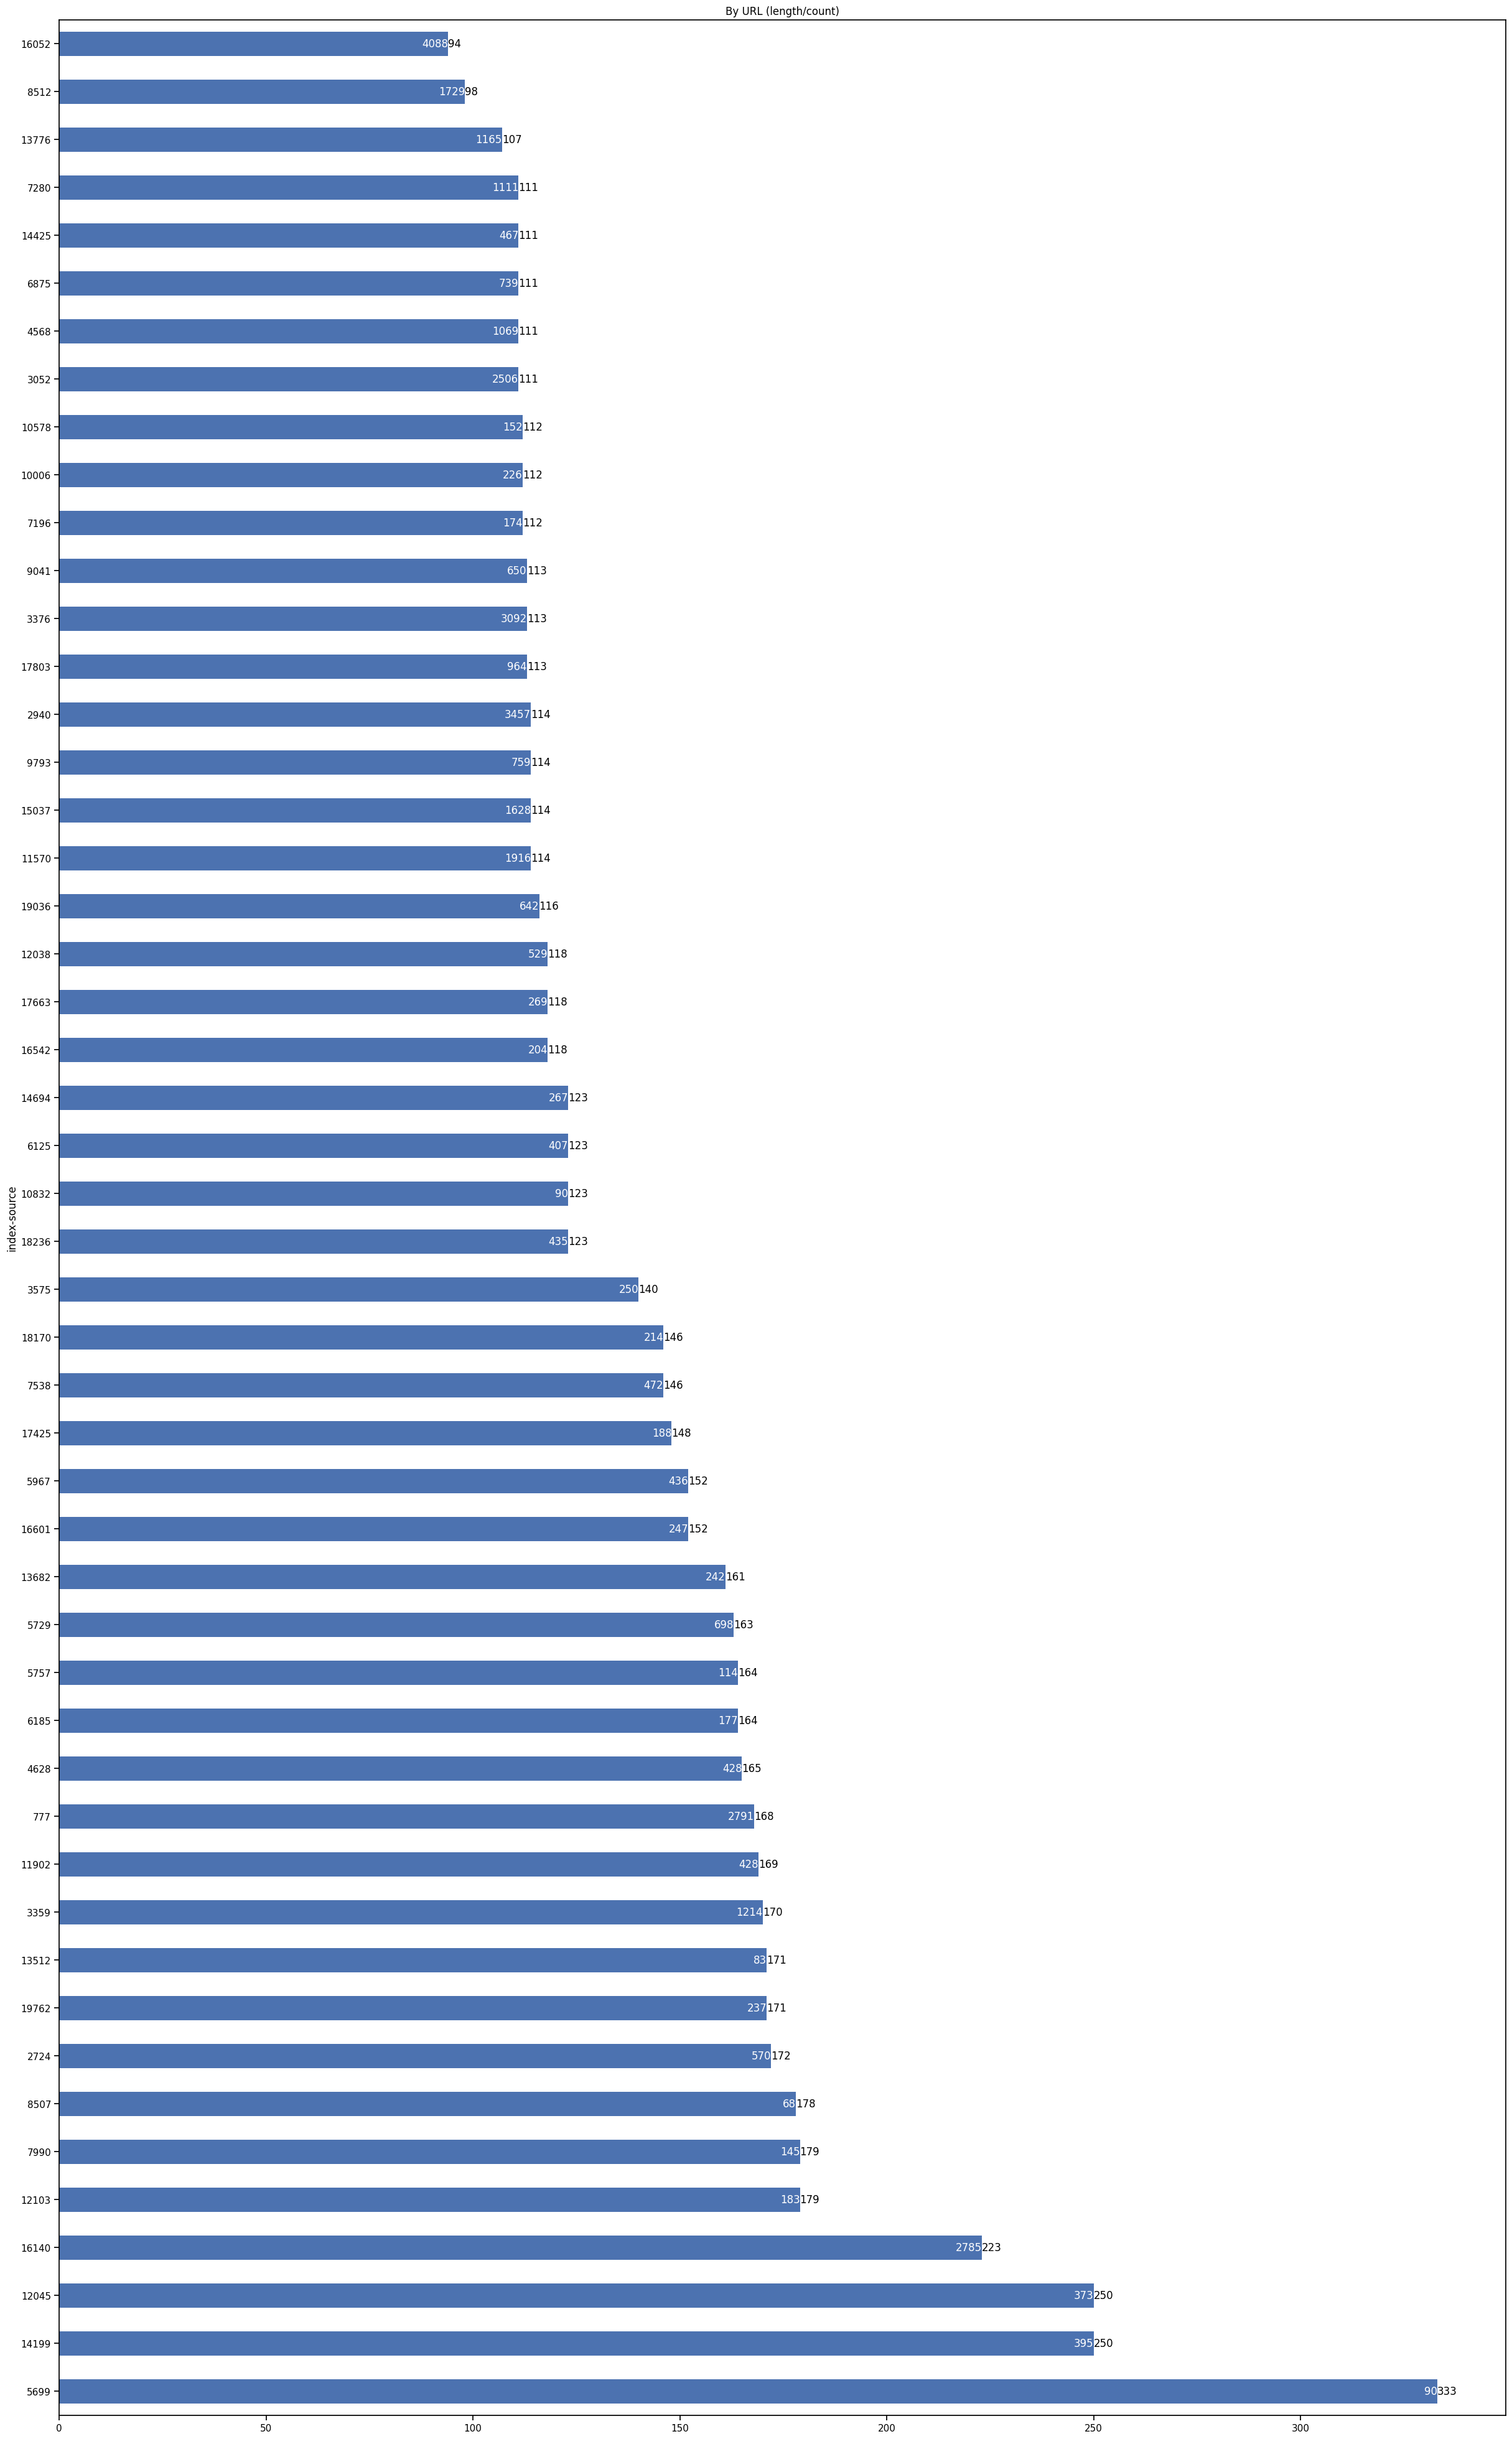

In [48]:
# plt.figure(figsize=(30, 50))
plt.title("By URL (length/count)")
plt.xlabel('Number of URLs')
plt.ylabel('Shader ID')

tmp = df_source_count.sort_values('index-url', ascending=False).head(50)
bar = tmp['index-url'].plot(kind='barh', figsize=(30, 50))
# bar = sns.barplot(x='url_count', y='index', hue='type', data=tmp, orient='h')
# label length on top of bar
for rect, url_count, length in zip(bar.patches,tmp['index-url'],tmp['shader_length']):
    bar.annotate(f'{url_count}',
                    (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                    ha='left', va='center')
    bar.annotate(f'{length}',
                    (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                    ha='right', va='center', color='white')
    
plt.show()

In [49]:
df_shaders_trim.head(2)

,index-program,index-context,index-url,url,category,duration,raf-accessTime,raf-rafFuncCountList,raf-title,raf-url,...,context-memoryInfo-resources-transformFeedback,context-memoryInfo-resources-vertexArray,context-type,program-isDeleted,program-isLinked,program-useCounts,shader_source,shader_type,shader_length,shader_source_trimmed_hashed
index-shader,,,,,,,,,,,,,,,,,,,,,
0,1,0,5,http://127.0.0.1:8000/test1/webgl/easy,[custom],30.827378,1681459501602,[2424],59.994 fps,http://127.0.0.1:8000/test1/webgl/easy,...,0.0,1.0,webgl2,False,True,2424,#version 300 es\n#ifdef GL_ES\nprecision mediu...,vertex,285,54f5ab1e8fa444d540f4eb64b68c5b6e4df8998f208518...
1,1,0,5,http://127.0.0.1:8000/test1/webgl/easy,[custom],30.827378,1681459501602,[2424],59.994 fps,http://127.0.0.1:8000/test1/webgl/easy,...,0.0,1.0,webgl2,False,True,2424,#version 300 es\n#ifdef GL_ES\nprecision mediu...,fragment,132,161c2a26d6c34ecee5147cc69beebb3cd50f40914a1423...


1. drop duplicates by (shader, XXXX)
2. calculate duplicity

Percentage of all unique shaders by shaders only: 33.09%
Percentage of all unique shaders by ['shader_source_trimmed_hashed', 'index-url']: 45.77%
Percentage of all unique shaders by ['shader_source_trimmed_hashed', 'index-context']: 41.35%
Percentage of all unique shaders by ['shader_source_trimmed_hashed', 'index-program']: 33.86%


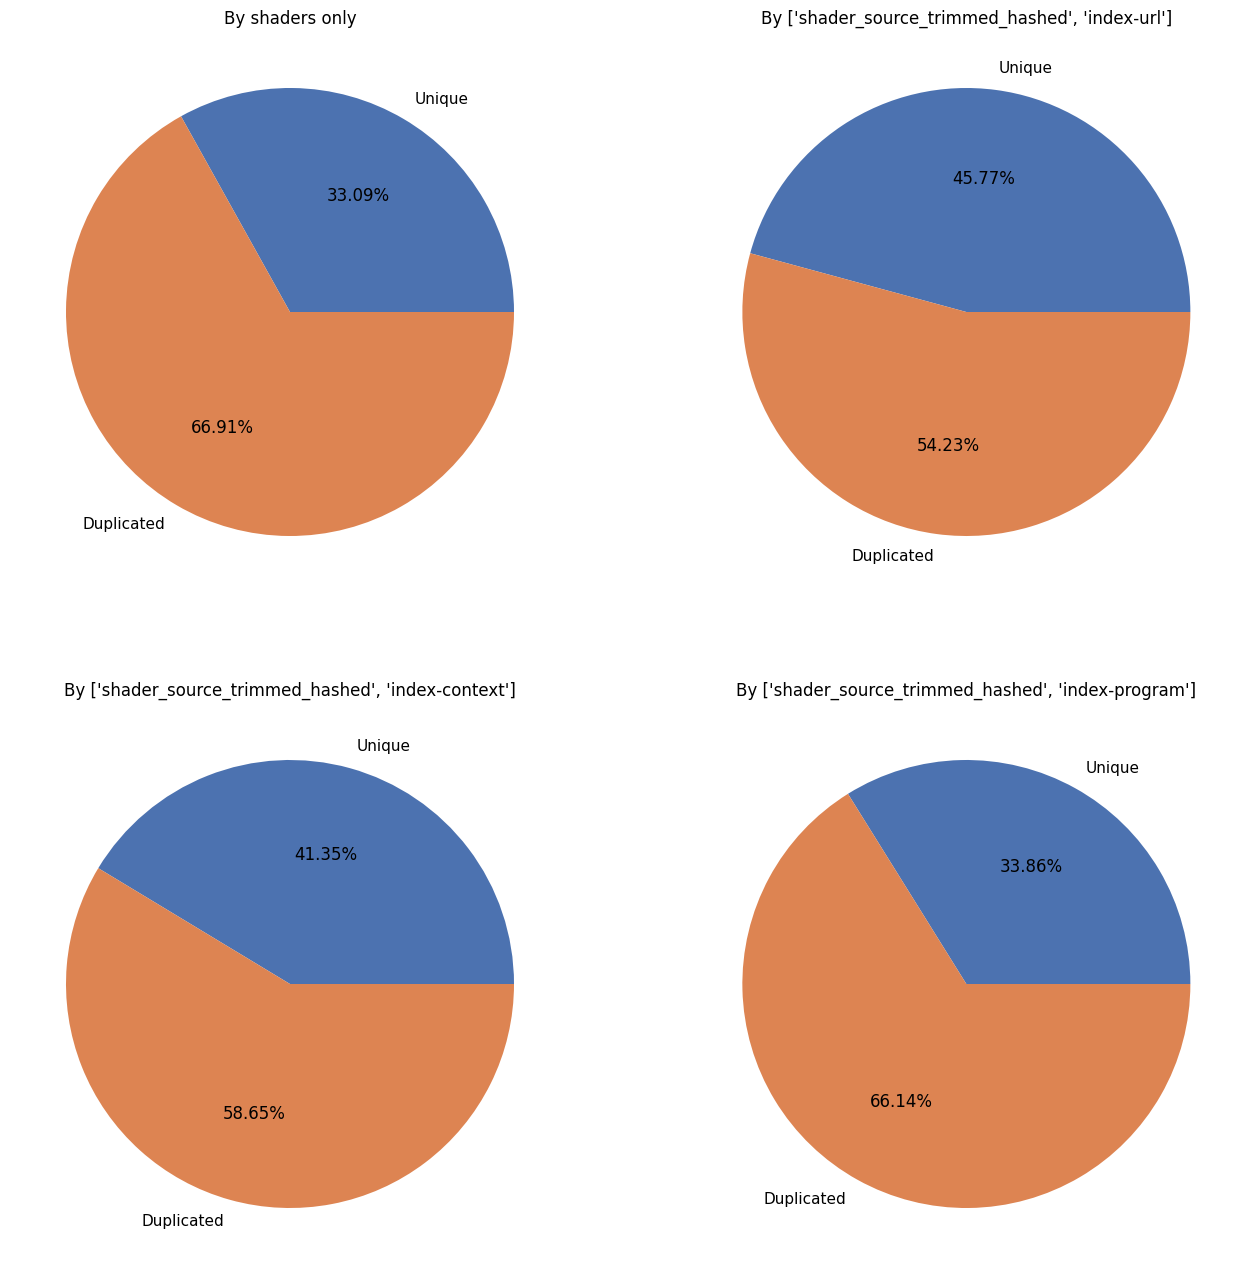

In [50]:
# create figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# add four figures above to the figure
subset = [None, ['shader_source_trimmed_hashed', 'index-url'], ['shader_source_trimmed_hashed', 'index-context'], ['shader_source_trimmed_hashed', 'index-program']]
for i in range(4):
    if subset[i] is None:
        df_shaders_trim_dedup = df_shaders_trim
    else:
        df_shaders_trim_dedup = df_shaders_trim.drop_duplicates(subset=subset[i], keep='first')
    # caculate the duplicity of df_shaders_trim_dedup, by column 'shader_source_trimmed_hashed'
    ratio = 1.0 - df_shaders_trim_dedup.duplicated(subset=['shader_source_trimmed_hashed'], keep='first').sum() / len(df_shaders_trim_dedup)
    by_str = str(subset[i]) if subset[i] is not None else 'shaders only'
    print("Percentage of all unique shaders by {}: {:.2f}%".format(by_str, ratio*100))
    axes[i//2][i%2].pie([ratio, 1-ratio], labels=['Unique', 'Duplicated'], autopct='%.2f%%')
    axes[i//2][i%2].set_title('By {}'.format(by_str))
plt.show()

In [51]:
# TODO

## Shader Count

In [52]:
df_shaders_trim.head(2)

,index-program,index-context,index-url,url,category,duration,raf-accessTime,raf-rafFuncCountList,raf-title,raf-url,...,context-memoryInfo-resources-transformFeedback,context-memoryInfo-resources-vertexArray,context-type,program-isDeleted,program-isLinked,program-useCounts,shader_source,shader_type,shader_length,shader_source_trimmed_hashed
index-shader,,,,,,,,,,,,,,,,,,,,,
0,1,0,5,http://127.0.0.1:8000/test1/webgl/easy,[custom],30.827378,1681459501602,[2424],59.994 fps,http://127.0.0.1:8000/test1/webgl/easy,...,0.0,1.0,webgl2,False,True,2424,#version 300 es\n#ifdef GL_ES\nprecision mediu...,vertex,285,54f5ab1e8fa444d540f4eb64b68c5b6e4df8998f208518...
1,1,0,5,http://127.0.0.1:8000/test1/webgl/easy,[custom],30.827378,1681459501602,[2424],59.994 fps,http://127.0.0.1:8000/test1/webgl/easy,...,0.0,1.0,webgl2,False,True,2424,#version 300 es\n#ifdef GL_ES\nprecision mediu...,fragment,132,161c2a26d6c34ecee5147cc69beebb3cd50f40914a1423...


count    4298.000000
mean       13.904141
std        29.559738
min         2.000000
50%         8.000000
75%        16.000000
90%        28.000000
95%        42.000000
99%        90.000000
max       918.000000
Name: shader_source_trimmed_hashed, dtype: float64

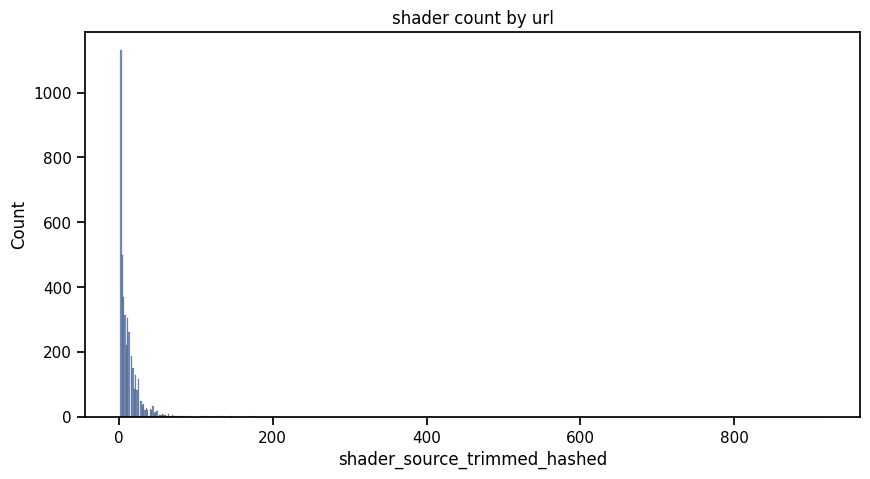

In [53]:
url_shader_count = df_shaders_trim.groupby('index-url')['shader_source_trimmed_hashed'].count()
plt.figure(figsize=(10, 5))
sns.histplot(data=url_shader_count, multiple="stack")
plt.title('shader count by url')
plt.plot()
url_shader_count.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

## shader length

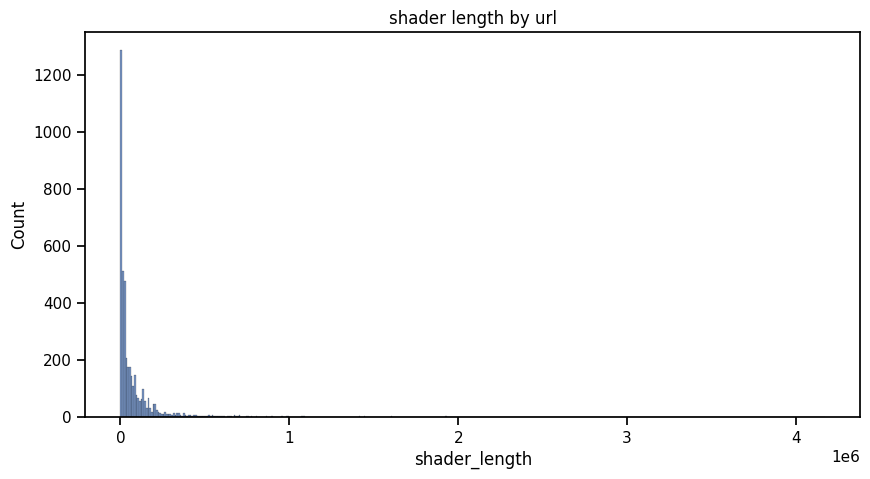

count    4.298000e+03
mean     9.199205e+04
std      2.061604e+05
min      2.120000e+02
50%      2.594000e+04
75%      8.917975e+04
90%      2.059170e+05
95%      3.753260e+05
99%      9.973746e+05
max      4.172150e+06
Name: shader_length, dtype: float64

In [54]:
url_shader_length = df_shaders_trim.groupby('index-url')['shader_length'].sum()
plt.figure(figsize=(10, 5))
sns.histplot(data=url_shader_length, multiple="stack")
plt.title('shader length by url')
plt.show()
url_shader_length.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

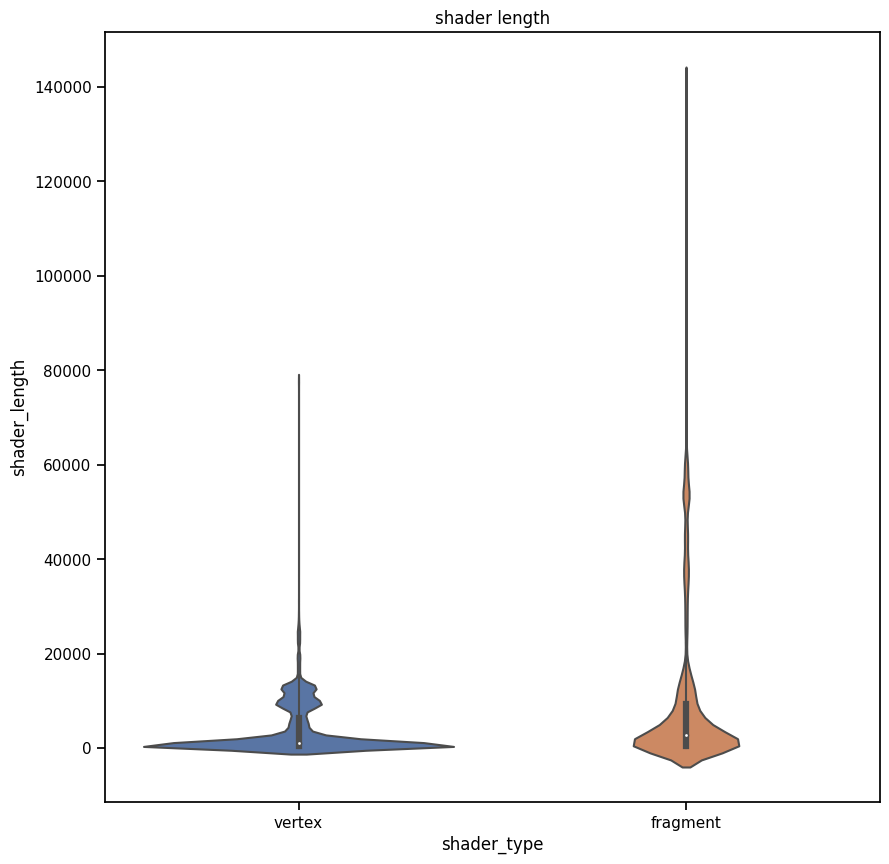

In [55]:
plt.figure(figsize=(10, 10))
# sns.histplot(data=df_shaders_trim_dedup, x="shader_length", hue="shader_type", multiple="layer", element="step")
sns.violinplot(data=df_shaders_trim, x="shader_type", y="shader_length")
plt.title('shader length')
plt.show()

# Programs

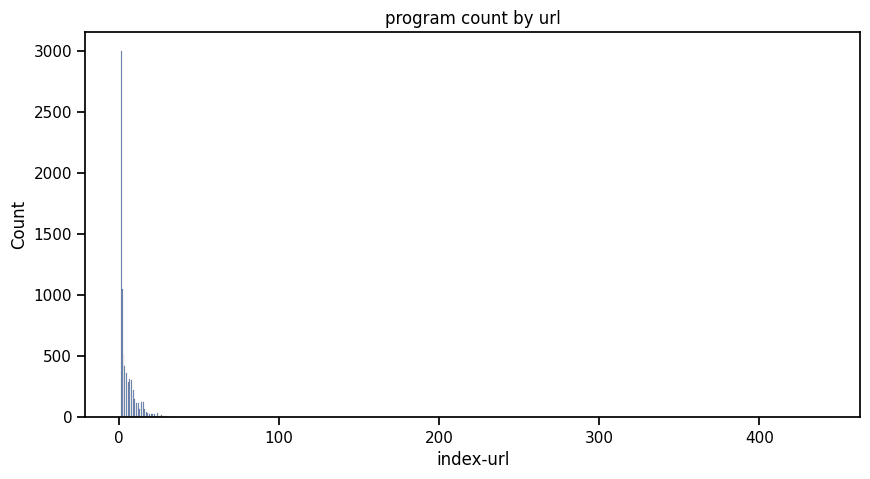

In [56]:
url_program_count = df_program.groupby('index-url')['index-url'].count()
plt.figure(figsize=(10, 5))
sns.histplot(data=url_program_count, multiple="stack")
plt.title('program count by url')
plt.show()

# Textures

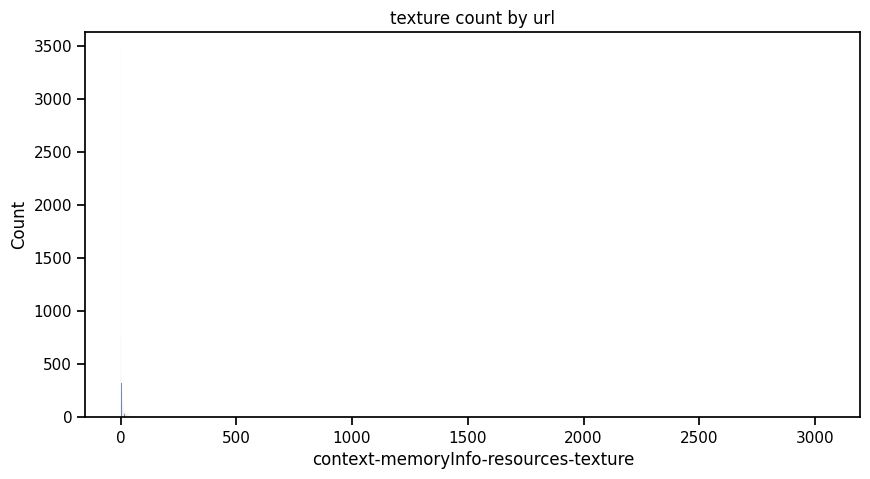

In [57]:
url_texture_count = df_context.groupby('index-url')['context-memoryInfo-resources-texture'].sum()
plt.figure(figsize=(10, 5))
sns.histplot(data=url_texture_count, multiple="stack")
plt.title('texture count by url')
plt.show()

# VAO

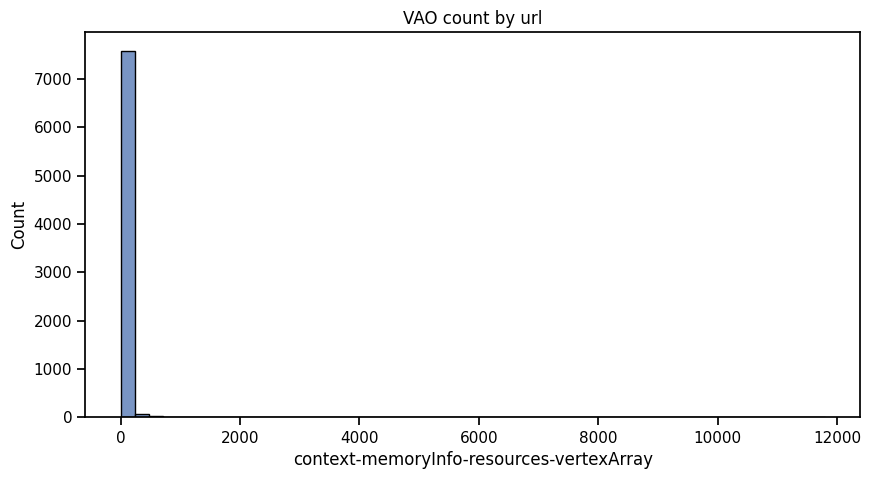

In [58]:
url_vao_count = df_context.groupby('index-url')['context-memoryInfo-resources-vertexArray'].sum()
plt.figure(figsize=(10, 5))
sns.histplot(data=url_vao_count, multiple="stack", bins=50)
plt.title('VAO count by url')
plt.show()

# Memory Total (roughly)

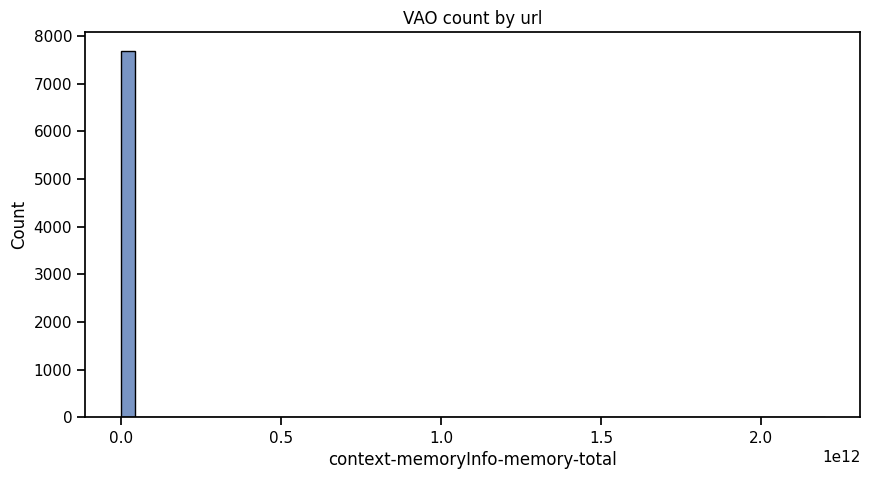

In [59]:
# context-memoryInfo-memory-total
url_mem_total_sum = df_context.groupby('index-url')['context-memoryInfo-memory-total'].sum()
plt.figure(figsize=(10, 5))
sns.histplot(data=url_mem_total_sum, multiple="stack", bins=50)
plt.title('VAO count by url')
plt.show()

# Vertex & Triangle

In [60]:
df_context['context-maghsk-counter-vertexCount'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    1.242500e+04
mean     9.263067e+07
std      7.369637e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.192560e+05
90%      5.124426e+07
95%      2.756076e+08
99%      2.151985e+09
max      3.663165e+10
Name: context-maghsk-counter-vertexCount, dtype: float64

In [61]:
df_context['context-maghsk-counter-semanticVertexCount']

index-context
0        {'0': 0, '1': 0, '2': 0, '3': 0, '4': 1453800,...
1        {'0': 0, '1': 0, '2': 0, '3': 0, '4': 11280000...
2        {'0': 0, '1': 0, '2': 0, '3': 0, '4': 15971400...
3        {'0': 0, '1': 0, '2': 0, '3': 0, '4': 1936764,...
4        {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...
                               ...                        
13669    {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...
13670    {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...
13671    {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...
13672    {'0': 0, '1': 477374, '2': 0, '3': 0, '4': 198...
13673    {'0': 0, '1': 606478, '2': 0, '3': 0, '4': 153...
Name: context-maghsk-counter-semanticVertexCount, Length: 12429, dtype: object

In [62]:
df_context['context-maghsk-counter-vertexCount'] = df_context['context-maghsk-counter-semanticVertexCount'].apply(lambda x: sum(y for y in x.values() if y is not None))

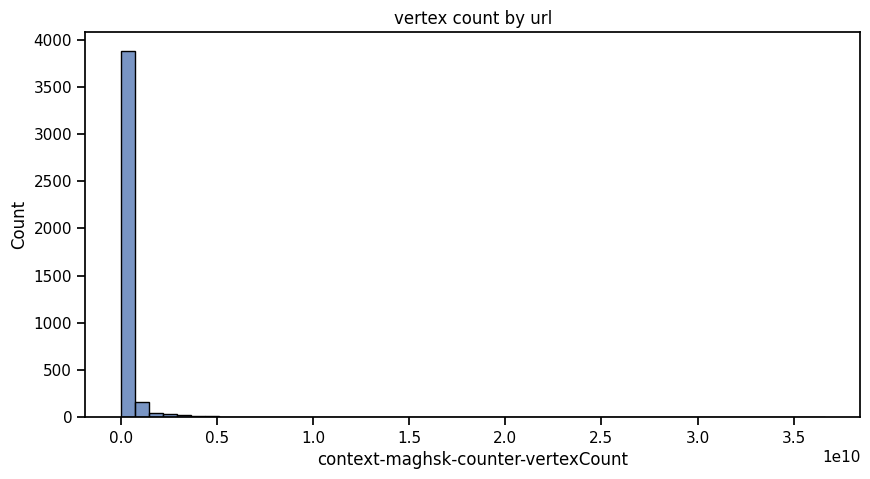

In [63]:
url_vertex_count = df_context.groupby('index-url')['context-maghsk-counter-vertexCount'].sum()
plt.figure(figsize=(10, 5))
sns.histplot(data=url_vertex_count[url_vertex_count>0], multiple="stack", bins=50)
plt.title('vertex count by url')
plt.show()

# Func Call

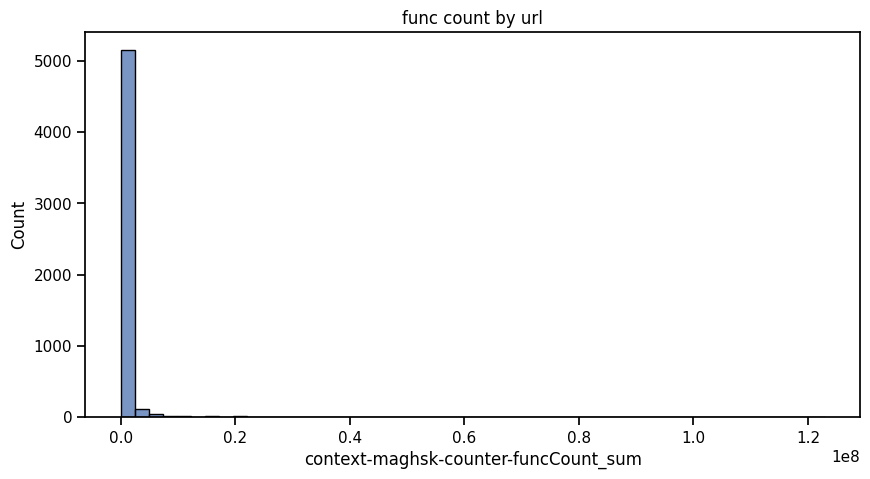

In [64]:
df_context['context-maghsk-counter-funcCount_sum'] = df_context['context-maghsk-counter-funcCount'].apply(lambda x: sum(y for y in x.values() if y is not None))
url_func_count = df_context.groupby('index-url')['context-maghsk-counter-funcCount_sum'].sum()
plt.figure(figsize=(10, 5))
sns.histplot(data=url_func_count[url_func_count>0], multiple="stack", bins=50)
plt.title('func count by url')
plt.show()